# Setup for Reviewer Figure 6A-H (Split Maze)

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [5]:
''' Complete List of Mice & Neural Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_1 excluded, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [6]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

# Edit these paths

In [54]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
shuffload_folder1 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/sparsitya/' # adjust to match location of this Dryad repo folder
shuffload_folder2 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/coherencea/' # adjust to match location of this Dryad repo folder
shuffload_folder3 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/peakheights/' # adjust to match location of this Dryad repo folder
shuffload_folder4 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/speedscores/' # adjust to match location of this Dryad repo folder
shuffload_folder5 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/speedstabscores/' # adjust to match location of this Dryad repo folder
int_save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS6/' # adjust to match Shuffle Procedure output plotsave_folder
figs2_folder = 'C:/Users/Python/Desktop/LocalData/FigureS2/' # adjust to match Figure S2 notebook save_folder

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/ReviewerFigure6/' 

In [8]:
''' Get reward & lick data for sessions w/ neural data'''

#get lick & reward data
rewarda_centers = []
rewardb_centers = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
 
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        d['reward_data'] = {}
        
        # get behavioral params
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1) # fixes occassional Unity error numbering of rewards 
        
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except:
            skippedtrials = []
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            
        reward_centers = np.array(reward['centers'][keep_idx])
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        auto_reward = np.array(reward['auto'][keep_idx])
        #print('Mouse ' + m + ' with n_misses: ' + str(np.sum(misses)))   

        # get lick and reward indices
        lick_ct = get.spiketrain(post, dt, lickt, index=False)
        d['reward_data']['lick_ct'] = lick_ct
        #print('got lick indices for mouse ' + m + ' session ' + s)
        
        reward_idx = get.rewardtrain(post, dt, rewardt, index=True) #gets reward ct for each time binned position range as index
        d['reward_data']['reward_idx'] = reward_idx
        #print('got reward indices for mouse ' + m + ' session ' + s)
    
    # saves list of reward locations per mouse
    if reward['centers'][0] == 270:
        rewarda_centers = np.append(rewarda_centers,270)
        rewardb_centers = np.append(rewardb_centers,370)
    else:
        rewarda_centers = np.append(rewarda_centers,370)
        rewardb_centers = np.append(rewardb_centers,270)            

In [9]:
''' Find & Save Number of Requested Rewards per Epoch per Session & Animal '''

#session arrays
req_rates = []
reqa_rates = []
reqb_rates = []
reqblock_rates = []
reqalt_rates = []
reqalta_rates = []
reqaltb_rates = []
req_trials = []
reqblock_trials = []
reqalt_trials = []

#animals arrays
mreq_rates = []
mreqa_rates = []
mreqb_rates = []
mreqblock_rates = []
mreqalt_rates = []
mreqalta_rates = []
mreqaltb_rates = []

for m, session in zip(mice, sessions):
    rt = []
    ca = []
    cb = []
    blocks = []
    alt = []
    alta = []
    altb = []
    
    req = []
    reqa = []
    reqb = []
    reqblocks = []
    reqalt = []
    reqalta = []
    reqaltb = []
    
    for s in session:
        # get behavior data
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            
        except:
            skippedtrials = []
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewarda = reward_centers[0]
        rewardb = reward_centers[60]
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        requests = ~misses
        
        # find rate of requests for a given session
        req_rates.append(np.sum(requests)/len(reward_trials)) #total
        
        rewarda_idx = np.where(reward_trials < 81)[0]
        reqa_rates.append(np.sum(requests[rewarda_idx])/len(rewarda_idx)) #context a
        
        rewardb_idx = np.intersect1d((np.where(reward_trials >= 81)), (np.where(reward_trials <= 140)))
        reqb_rates.append(np.sum(requests[rewardb_idx])/len(rewardb_idx)) #context b
        
        block_idx = np.where(reward_trials < 140)[0]
        reqblock_rates.append(np.sum(requests[block_idx])/len(block_idx)) #block
        
        alt_idx = np.where(reward_trials >= 140)[0]
        reqalt_rates.append(np.sum(requests[alt_idx])/len(alt_idx)) #alt
        
        alta_idx = np.where((reward_trials >= 140) & (reward_centers == rewarda))[0] 
        reqalta_rates.append(np.mean(requests[alta_idx]))
        
        altb_idx = np.where((reward_trials >= 140) & (reward_centers == rewardb))[0]
        reqaltb_rates.append(np.mean(requests[altb_idx]))
        
        rt = np.append(rt,len(reward_trials))
        ca = np.append(ca,len(rewarda_idx))
        cb = np.append(cb,len(rewardb_idx))
        blocks = np.append(blocks,len(block_idx))
        alt = np.append(alt,len(alt_idx))
        alta = np.append(alta, len(alta_idx))
        altb = np.append(altb, len(altb_idx))
        
        req_trials = np.append(req_trials, len(reward_trials))
        reqblock_trials = np.append(reqblock_trials, len(block_idx))
        reqalt_trials = np.append(reqalt_trials, len(alt_idx))
        
        req = np.append(req,np.sum(requests))
        reqa = np.append(reqa,np.sum(requests[rewarda_idx]))
        reqb = np.append(reqb,np.sum(requests[rewardb_idx]))
        reqblocks = np.append(reqblocks,np.sum(requests[block_idx]))
        reqalt = np.append(reqalt,np.sum(requests[alt_idx]))
        reqalta = np.append(reqalta,requests[alta_idx])
        reqaltb = np.append(reqaltb,requests[altb_idx])
        
        d['altreqbytrial'] = requests[alt_idx]
        
    # get mouse request rate collapsing days
    mreqrate = np.sum(req)/ np.sum(rt)
    mreq_rates = np.append(mreq_rates,mreqrate)
    
    mreqarate = np.sum(reqa) / np.sum(ca)
    mreqa_rates = np.append(mreqa_rates, mreqarate)
    
    mreqbrate = np.sum(reqb) / np.sum(cb)
    mreqb_rates = np.append(mreqb_rates, mreqbrate)
    
    mreqblockrate = np.sum(reqblocks) / np.sum(blocks)
    mreqblock_rates = np.append(mreqblock_rates, mreqblockrate)
    
    mreqaltrate = np.sum(reqalt) / np.sum(alt)
    mreqalt_rates = np.append(mreqalt_rates, mreqaltrate)
    
    mreqalta_rates = np.append(mreqalta_rates, np.mean(reqalta))
    mreqaltb_rates = np.append(mreqaltb_rates, np.mean(reqaltb))
    
# save as arrays to be safe
req_rates = np.asarray(req_rates)
reqa_rates = np.asarray(reqa_rates)
reqb_rates = np.asarray(reqb_rates)
reqblock_rates = np.asarray(reqblock_rates)
reqalt_rates = np.asarray(reqalt_rates)
reqalta_rates = np.asarray(reqalta_rates)
reqaltb_rates = np.asarray(reqaltb_rates)

mreq_rates = np.asarray(mreq_rates)
mreqa_rates = np.asarray(mreqa_rates)
mreqb_rates = np.asarray(mreqb_rates)
mreqblock_rates = np.asarray(mreqblock_rates)
mreqalt_rates = np.asarray(mreqalt_rates)
mreqalta_rates = np.asarray(reqalta_rates)
mreqaltb_rates = np.asarray(reqaltb_rates)

In [11]:
''' Load indices corresponding to quarters of the task sorted by context, making sure skipped trials are excluded.

Generated in Figure S2 notebook. Please run that before proceeding.

''' 

for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
        
        #save indices for session sections
        Aidx_file = 'Aidx_' + m + '_' + s +'.npy'
        Bidx_file = 'Bidx_' + m + '_' + s +'.npy'
        A_idx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_idx_file = 'B_idx_' + m + '_' + s +'.npy'
        A_ngidx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_ngidx_file = 'B_idx_' + m + '_' + s +'.npy'
        
        Aidx = np.load(figs2_folder + Aidx_file)
        Bidx = np.load(figs2_folder + Bidx_file)
        A_idx = np.load(figs2_folder + A_idx_file)
        B_idx = np.load(figs2_folder + B_idx_file)
        
        d['Aidx'] = Aidx
        d['Bidx'] = Bidx
        d['A_idx'] = A_idx
        d['B_idx'] = B_idx

        #Also load A`& B` indices excluding gain change trials in each context
        A_ngidx = np.load(figs2_folder + A_ngidx_file)
        B_ngidx = np.load(figs2_folder + B_ngidx_file)
        
        d['A_ngidx'] = A_ngidx
        d['B_ngidx'] = B_ngidx

In [15]:
''' Gather total number of SM cells'''

young_count = 0
MA_count = 0
age_count = 0

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        if m in SM_aged_mice:
            age_count += len(cell_IDs)
        elif m in SM_MA_mice:
            MA_count += len(cell_IDs)
        else:
            young_count += len(cell_IDs)
            
print(young_count, MA_count, age_count)

15152 15011 13225


# Classify spatial cells using shuffle results at a lower threshold

In [14]:
''' Load saved scores to classify spatial cells

Notes: intn booleans are produced by the notebook "Shuffle Procedure..." Run the first part of that for all sessions before 
proceeding here. 

The Fig S2 notebook produces the scores loaded below to classify spatial cells. Run that before proceeding.

'''

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #get file names
        shufsparsityascore_file = 'shufsparsityascores_' + m + '_' + s + '.npy'
        shufspatialacoherencescore_file = 'shufspatialacoherencescores_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'
        sparsityascore_file = 'sparsityascores_' + m + '_' + s + '.npy'
        spatialacoherencescore_file = 'spatialacoherencescores_' + m + '_' + s + '.npy' 

        #load npy files       

        d['shuffsparsityascores'] = np.load(shuffload_folder1 + shufsparsityascore_file, allow_pickle=False)
        d['shuffspatialacoherencescores'] = np.load(shuffload_folder2 + shufspatialacoherencescore_file, allow_pickle=False)
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        d['intn'] = d['intn'].astype(bool)    
        d['spatialasparsity'] = np.load(figs2_folder + sparsityascore_file, allow_pickle=True)
        d['spatialacoherencescores'] = np.load(figs2_folder + spatialacoherencescore_file, allow_pickle=True)

In [16]:
''' Classify Spatial Cells at P95 Threshold from Context A Sparsity & Coherence '''

per95c = []
per95s = []
dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        
        cell_IDs = raw.item().get('cellsfil')
        sparsitya_scores = d['spatialasparsity']
        spatialacoherence_scores = d['spatialacoherencescores']
        shuffsparsityascores = d['shuffsparsityascores'] 
        shuffspatialacoherencescores = d['shuffspatialacoherencescores'] 
        intn = d['intn']

        #Classify spatial cells as those > P95 of both Contexte A shuffle sparsity & coherence score distributions
        spatialcell95 = []
        for i, c in enumerate(cell_IDs):

            dist1 = shuffspatialacoherencescores[:,i]
            P951 = np.nanpercentile(dist1,95)

            dist2 = shuffsparsityascores[:,i]
            P952 = np.nanpercentile(dist2,95)
            
            per95c.append(P951)
            per95s.append(P952)

            if intn[i] == True: #spatial cells must be excitatory
                spatialcell95 = np.append(spatialcell95, False)
            elif (spatialacoherence_scores[i] > P951) & (sparsitya_scores[i] > P952):
                spatialcell95 = np.append(spatialcell95, True)
            else:
                spatialcell95 = np.append(spatialcell95, False)
        spatialcell95 = np.asarray(spatialcell95).astype(bool)

        #save speed cell IDs in nested list for all animals
        d['spatialcell95'] = spatialcell95    
        #print('% spatial cells = ' + str(100*len(cell_IDs[spatialcell95])/len(cell_IDs)))
        
        spatialcell95_file = 'spatialcell95_' + m + '_' + s + '.npy'
        #np.save(save_folder + spatialcell95_file, spatialcell95)
        #print('saved spatial cell booleans as npy files for mouse ' + m + ' session '+ s)

print('\nMean ± SEM Coherence P95: ' + str(np.nanmean(per95c)) + ' ± ' + str(stats.sem(per95c, nan_policy = 'omit')))
print('Mean ± SEM Sparsity P95:' + str(np.nanmean(per95s)) + ' ± ' + str(stats.sem(per95s,  nan_policy = 'omit'))) 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Mean ± SEM Coherence P95: 0.3910526001251149 ± 0.0007825185327001357
Mean ± SEM Sparsity P95:1.4206468773988374 ± 0.012832039772898058


# Classify non-grid vs. grid cells at a lower threshold

In [17]:
'''Classify grid vs. non-grid cells at P95 peak height threshold and with FR thresholds. 

Run time < 1 min / session (167 sessions)'''

track_length = 400 #cm
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20 #trials
lags = np.arange(0,801,1)

perngs = []
pergrid = []
for m, session in zip(mice,sessions):
    
    for s in tdqm(session):
        
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        rawtrialfil = raw.item().get('trialfil')
        
        Aidx = d['Aidx']
        Bidx = d['Bidx']
        
        #get dark-only, normalized, smoothed spatial map & reshape into continuous vector for each cell
        FR, _ , _ = ps.tuning_curve_bytrial(posxfil, trial, Y, dt, sigma = 2, b= 2, smooth=True, normalize=True, occupancy=True)
        stop_idx = np.where(trials == n_dark)[0][0]
        FR = FR[:stop_idx,:,:]
        n_trials = FR.shape[0]
        n_pos = FR.shape[1]
        n_cells = FR.shape[2]
        FR = (np.reshape(FR, (n_trials*n_pos, n_cells))).T
        
        #load in spatial cells & interneurons classified elsewhere
        spatialcell95 = d['spatialcell95']
        spatialcells = cell_IDs[spatialcell95]
        intn = d['intn']
        
        #find max autocorrelation peaks for all cells; store height & prom of most prominent peak
        peak = [] # boolean if peak found
        maxpeak_locs = [] #stored lag of max peak if peak exist
        maxpeak_heights = [] # stored height of max peak, otherwise 0 if not exist
        maxpeak_proms = [] # stored prominence of max peak, otherwise 0 if not exist
        for i, c in enumerate(cell_IDs):
            sdx = np.where(cell_IDs == c)[0][0]
            autocorrelation = get.autocorr(FR[sdx,:], lags)
            normauto = autocorrelation / autocorrelation[0]
            peaks, properties = find_peaks(normauto, width = 10, height = 0.10, prominence = 0.15)
            proms = properties["prominences"]
            heights = properties["peak_heights"]

            if peaks.size > 0:
                peak = np.append(peak,1)
                maxpeak_locs = np.append(maxpeak_locs, peaks[np.argmax(proms)])
                maxpeak_heights = np.append(maxpeak_heights, heights[np.argmax(proms)])
                maxpeak_proms = np.append(maxpeak_proms, proms[np.argmax(proms)])
            else:
                peak = np.append(peak,0)
                maxpeak_heights = np.append(maxpeak_heights,0)
                maxpeak_proms = np.append(maxpeak_proms,0)         
        peak = peak.astype(bool)
        
        #define low FR cell group (mean FR <0.05 in the dark; 0.3 Hz overall); to be removed from grid cell group
        stop_idx = np.where(trial <= 19)[0][-1].astype(int)
        darkFR, _ , _ = ps.tuning_curve_bytrial(posxfil[:stop_idx], trial[:stop_idx], Y[:stop_idx,:], dt, sigma = 2, b = 2, smooth=True, normalize=False, occupancy=True)
        FR, _, _ = ps.tuning_curve(posxfil, Y, dt, b=2, smooth=True, l=2, SEM=False, occupancy=False)
        lowfrcells = []
        lowdarkfrcells = []
        for i, c in enumerate(cell_IDs):
            if np.mean(np.mean(darkFR[:,:,i], axis = 1)) <= 0.05:
                lowdarkfrcells = np.append(lowdarkfrcells, c)
            elif np.mean(FR[:,i]) < 0.3:
                lowfrcells = np.append(lowfrcells, c)      
                
        #define indices excluding reward zone starts
        reward = raw.item().get('reward')
        centers = reward['centers']
        centera = centers[0]
        if centera == 270:
            centerb = 370
        else:
            centerb = 270
        
        # generate aligned position tuning curve
        aFR, abinned_pos, aFR_sem, occ = ps.tuning_curve(posxfil[Aidx], Y[Aidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        bFR, bbinned_pos, bFR_sem, occ = ps.tuning_curve(posxfil[Bidx], Y[Bidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        
        #find indices of bins not including 50cm pre-post reward centers (220 to 255 and 320 to 355)
        aidx = np.where((abinned_pos > (centera - 50)) & (abinned_pos <= (centera - 15)))
        maska = np.ones(len(abinned_pos), bool)
        maska[aidx] = 0
        bidx = np.where((bbinned_pos > (centerb - 50)) & (bbinned_pos <= (centerb - 15)))
        maskb = np.ones(len(bbinned_pos), bool)
        maskb[bidx] = 0
        
        noisycells = []
        for i, c in enumerate(cell_IDs):
            if (np.mean(aFR_sem[maska,i]) > np.mean(aFR[maska,i])*.45) and (np.mean(bFR_sem[maskb,i]) > np.mean(bFR[maskb,i])*.45):
                noisycells = np.append(noisycells, c)
        
        #classify grid cells based on peak prominence > P99 shuffle height
        shufmaxpeak_heights_file = 'shufmaxpeak_heights__' + m + '_' + s + '.npy'
        shuffmaxpeak_heights = np.load(shuffload_folder3 + shufmaxpeak_heights_file)
    
        gridcell = []
        for i, c in enumerate(cell_IDs):
            #require that grid cells have at least one peak larger than 0.15 prominence, height 0.1, width = 10 in the dark
            #also require that prom of peak exceeds P99 of shuffle autocorrelation height distribution autocorrelations at that same lag
            #also require that that cell is not an interneuron
    
            if (intn[i] == 0) & (peak[i] == 1):
                idx = np.where(cell_IDs[peak] == c)[0][0]
                dist = shuffmaxpeak_heights[:,idx]
                P99 = np.percentile(dist,99)
                P95 = np.percentile(dist,95)

                if (maxpeak_proms[i] >= P95):
                    gridcell = np.append(gridcell, 1)
                else:
                    gridcell = np.append(gridcell, 0)
            else: 
                gridcell = np.append(gridcell, 0)
                
        #Find non-distance coding spatial cells to be ngs cells; then further            
        ngscell = []
        for i, c in enumerate(cell_IDs):
            #ngs cells are any spatial cells that do not meet distance-coding cell criteria or meet that criteria with a
            #very low dark FR 
            if (intn[i] == 1) | (gridcell[i] == 1) | (spatialcell95[i] == 0):
                ngscell = np.append(ngscell, 0)
            elif (peak[i] == 1): #remove any low quality grid cells that have a peak 
                idx = np.where(cell_IDs[peak] == c)[0][0]
                P90 = np.percentile(dist, 90)
                
                if (maxpeak_proms[i] >= P90) & (maxpeak_proms[i] < P99):
                    ngscell = np.append(ngscell, 0)
                elif (intn[i] == 0) & (gridcell[i] == 0) & (spatialcell95[i] == 1): 
                    ngscell = np.append(ngscell, 1)
                else: 
                    ngsell = np.append(ngscell, 0)
            elif (c not in lowdarkfrcells) & (peak[i] == 0) & (intn[i] == 0) & (spatialcell95[i] == 1):
                ngscell = np.append(ngscell, 1)
            else: 
                ngscell = np.append(ngscell, 0)
                
        # filter out noisy cells from both grid and ngs cells and low firing grid cells    
        for i, c in enumerate(cell_IDs):
            #also require that dark FR > 0.05 Hz and mean FR > 0.3 Hz
            if (c in lowfrcells) or (c in lowdarkfrcells):
                gridcell[i] = 0
                
            if (c in noisycells):
                gridcell[i] = 0
                ngscell[i] = 0
                
        #Save booleans
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        d['gridcell'] = gridcell
        d['ngscell'] = ngscell
        
        #gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
        #np.save(save_folder + gridcell_file, gridcell.astype(bool))
        #print('saved grid cell boolean for spatial cells as npy file for mouse ' + m + ' session '+ s)
                
        #ngscell_file = 'bordercell__' + m + '_' + s + '.npy'
        #np.save(save_folder + ngscell_file, d['ngscell'])
        #print('saved ngs cell boolean for spatial cells as npy file for mouse ' + m + ' session '+ s)

        #save percentages of grid vs. ngs cells
        print(m + ', ' + s + ' n grid, ngs cells: '+ str(np.sum(gridcell)) + ' , ' + str(np.sum(ngscell)))
        perngs = np.append(perngs, 100*np.sum(ngscell)/len(cell_IDs))
        pergrid = np.append(pergrid, 100*np.sum(gridcell)/len(cell_IDs))

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Python\Desktop\GitHub\Herber2024\pipeline\get_data.py:380: RuntimeWarning: invalid value encountered in divide
  corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)


A14, 083022_record1 n grid, ngs cells: 19 , 54
A14, 083122_record2 n grid, ngs cells: 51 , 5
A14, 090122_record3 n grid, ngs cells: 18 , 15


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n grid, ngs cells: 5 , 7
A15, 083122_record2 n grid, ngs cells: 90 , 34
A15, 090122_record3 n grid, ngs cells: 97 , 37
A15, 090222_record4 n grid, ngs cells: 150 , 71
A15, 090322_record5 n grid, ngs cells: 54 , 33
A15, 090422_record6 n grid, ngs cells: 28 , 19


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n grid, ngs cells: 25 , 25
A16, 083122_record2 n grid, ngs cells: 64 , 35
A16, 090122_record3 n grid, ngs cells: 0 , 2
A16, 090222_record4 n grid, ngs cells: 18 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n grid, ngs cells: 2 , 2
A17, 082422_record2 n grid, ngs cells: 2 , 7
A17, 082522_record3 n grid, ngs cells: 46 , 40
A17, 082622_record4 n grid, ngs cells: 48 , 21
A17, 082722_record5 n grid, ngs cells: 46 , 22
A17, 082822_record6 n grid, ngs cells: 61 , 24


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n grid, ngs cells: 18 , 11
A18, 082422_record2 n grid, ngs cells: 100 , 151
A18, 082522_record3 n grid, ngs cells: 90 , 122
A18, 082622_record4 n grid, ngs cells: 58 , 78
A18, 082722_record5 n grid, ngs cells: 52 , 11
A18, 082822_record6 n grid, ngs cells: 0 , 34


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n grid, ngs cells: 27 , 1
A19, 012823_record3 n grid, ngs cells: 31 , 78
A19, 012923_record4 n grid, ngs cells: 52 , 69
A19, 013023_record5 n grid, ngs cells: 67 , 34
A19, 013123_record6 n grid, ngs cells: 46 , 18
A19, 020123_record7 n grid, ngs cells: 66 , 22


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n grid, ngs cells: 7 , 19
A20, 012723_record2 n grid, ngs cells: 36 , 45
A20, 012823_record3 n grid, ngs cells: 78 , 52
A20, 012923_record4 n grid, ngs cells: 28 , 44
A20, 013023_record5 n grid, ngs cells: 34 , 51
A20, 013123_record6 n grid, ngs cells: 12 , 34


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n grid, ngs cells: 64 , 34
A22, 013023_record3 n grid, ngs cells: 109 , 95
A22, 013123_record4 n grid, ngs cells: 64 , 43
A22, 020123_record5 n grid, ngs cells: 11 , 12
A22, 020223_record6 n grid, ngs cells: 40 , 34
A22, 020323_record7 n grid, ngs cells: 19 , 6


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n grid, ngs cells: 6 , 8
A23, 021023_record2 n grid, ngs cells: 35 , 63
A23, 021123_record3 n grid, ngs cells: 38 , 63
A23, 021223_record4 n grid, ngs cells: 13 , 4
A23, 021323_record5 n grid, ngs cells: 34 , 37
A23, 021423_record6 n grid, ngs cells: 58 , 52


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n grid, ngs cells: 49 , 37
A24, 022723_record2 n grid, ngs cells: 122 , 75
A24, 022823_record3 n grid, ngs cells: 71 , 61
A24, 030123_record4 n grid, ngs cells: 77 , 29
A24, 030223_record5 n grid, ngs cells: 58 , 27
A24, 030323_record6 n grid, ngs cells: 22 , 17


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n grid, ngs cells: 80 , 93
MA10F, 111422_record2 n grid, ngs cells: 71 , 41
MA10F, 111522_record3 n grid, ngs cells: 46 , 27
MA10F, 111622_record4 n grid, ngs cells: 27 , 23
MA10F, 111722_record5 n grid, ngs cells: 29 , 23
MA10F, 111822_record6 n grid, ngs cells: 54 , 76


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n grid, ngs cells: 36 , 23
MA1F, 102422_record2 n grid, ngs cells: 62 , 26
MA1F, 102522_record3 n grid, ngs cells: 56 , 22
MA1F, 102622_record4 n grid, ngs cells: 11 , 9
MA1F, 102722_record5 n grid, ngs cells: 85 , 46
MA1F, 102822_record6 n grid, ngs cells: 84 , 26


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n grid, ngs cells: 57 , 80
MA2F, 102422_record2 n grid, ngs cells: 53 , 94
MA2F, 102522_record3 n grid, ngs cells: 78 , 103
MA2F, 102622_record4 n grid, ngs cells: 49 , 63
MA2F, 102722_record5 n grid, ngs cells: 44 , 48
MA2F, 102822_record6 n grid, ngs cells: 54 , 39


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n grid, ngs cells: 11 , 20
MA3M, 102422_record2 n grid, ngs cells: 43 , 62
MA3M, 102522_record3 n grid, ngs cells: 43 , 56
MA3M, 102622_record4 n grid, ngs cells: 17 , 58
MA3M, 102722_record5 n grid, ngs cells: 18 , 30
MA3M, 102822_record6 n grid, ngs cells: 37 , 45


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n grid, ngs cells: 45 , 53
MA4M, 110122_record3 n grid, ngs cells: 32 , 25
MA4M, 110222_record4 n grid, ngs cells: 11 , 11
MA4M, 110322_record5rep n grid, ngs cells: 30 , 21
MA4M, 110422_record6 n grid, ngs cells: 51 , 40
MA4M, 110522_record7 n grid, ngs cells: 13 , 10


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n grid, ngs cells: 78 , 26
MA5M, 110722_record2 n grid, ngs cells: 74 , 61
MA5M, 110822_record3 n grid, ngs cells: 93 , 32
MA5M, 110922_record4 n grid, ngs cells: 11 , 13
MA5M, 111022_record5 n grid, ngs cells: 29 , 29
MA5M, 111122_record6 n grid, ngs cells: 29 , 25


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n grid, ngs cells: 38 , 78
MA6M, 103122_record2 n grid, ngs cells: 26 , 43
MA6M, 110122_record3 n grid, ngs cells: 84 , 55
MA6M, 110222_record4 n grid, ngs cells: 10 , 14
MA6M, 110322_record5 n grid, ngs cells: 15 , 7
MA6M, 110422_record6 n grid, ngs cells: 44 , 34


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n grid, ngs cells: 34 , 35
MA7M, 103122_record2 n grid, ngs cells: 45 , 49
MA7M, 110122_record3 n grid, ngs cells: 25 , 34
MA7M, 110222_record4 n grid, ngs cells: 11 , 8


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n grid, ngs cells: 22 , 7
MA8F, 111422_record2 n grid, ngs cells: 77 , 58
MA8F, 111522_record3 n grid, ngs cells: 86 , 29
MA8F, 111622_record4 n grid, ngs cells: 32 , 31
MA8F, 111722_record5 n grid, ngs cells: 20 , 23
MA8F, 111822_record6 n grid, ngs cells: 14 , 20


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n grid, ngs cells: 68 , 37
MA9F, 111422_record2 n grid, ngs cells: 97 , 171
MA9F, 111522_record3 n grid, ngs cells: 137 , 89
MA9F, 111622_record4 n grid, ngs cells: 0 , 1
MA9F, 111722_record5 n grid, ngs cells: 28 , 31
MA9F, 111822_record6 n grid, ngs cells: 28 , 21


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n grid, ngs cells: 13 , 5
Y20, 092622_record2 n grid, ngs cells: 39 , 32
Y20, 092722_record3 n grid, ngs cells: 15 , 14
Y20, 092822_record4 n grid, ngs cells: 58 , 32
Y20, 092922_record5 n grid, ngs cells: 23 , 11
Y20, 093022_record6 n grid, ngs cells: 98 , 64


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n grid, ngs cells: 116 , 68
Y21, 091922_record2 n grid, ngs cells: 105 , 105
Y21, 092022_record3 n grid, ngs cells: 61 , 29
Y21, 092122_record4 n grid, ngs cells: 72 , 61
Y21, 092222_record5 n grid, ngs cells: 58 , 51
Y21, 092322_record6 n grid, ngs cells: 12 , 30


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n grid, ngs cells: 93 , 53
Y22, 092622_record2 n grid, ngs cells: 163 , 57
Y22, 092722_record3 n grid, ngs cells: 75 , 91
Y22, 092822_record4 n grid, ngs cells: 27 , 24
Y22, 092922_record5 n grid, ngs cells: 23 , 27
Y22, 093022_record6 n grid, ngs cells: 67 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n grid, ngs cells: 48 , 25
Y23, 092622_record2 n grid, ngs cells: 35 , 27
Y23, 092722_record3 n grid, ngs cells: 41 , 44
Y23, 092822_record4 n grid, ngs cells: 31 , 30
Y23, 092922_record5 n grid, ngs cells: 43 , 53
Y23, 093022_record6 n grid, ngs cells: 72 , 81


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n grid, ngs cells: 103 , 66
Y24, 091922_record2 n grid, ngs cells: 43 , 76
Y24, 092022_record3 n grid, ngs cells: 101 , 58
Y24, 092122_record4 n grid, ngs cells: 106 , 59
Y24, 092222_record5 n grid, ngs cells: 74 , 48
Y24, 092322_record6 n grid, ngs cells: 79 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n grid, ngs cells: 0 , 1
Y25, 021723_record2 n grid, ngs cells: 95 , 45
Y25, 021823_record3 n grid, ngs cells: 46 , 68
Y25, 021923_record4 n grid, ngs cells: 52 , 58
Y25, 022023_record5 n grid, ngs cells: 62 , 50
Y25, 022123_record6 n grid, ngs cells: 29 , 19


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n grid, ngs cells: 42 , 43
Y26, 021723_record2 n grid, ngs cells: 67 , 22
Y26, 021823_record3 n grid, ngs cells: 25 , 30
Y26, 021923_record4 n grid, ngs cells: 2 , 2
Y26, 022023_record5 n grid, ngs cells: 20 , 20
Y26, 022123_record6 n grid, ngs cells: 6 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n grid, ngs cells: 59 , 46
Y27, 021723_record2 n grid, ngs cells: 43 , 18
Y27, 021823_record3 n grid, ngs cells: 37 , 20
Y27, 021923_record4 n grid, ngs cells: 22 , 19
Y27, 022023_record5rep n grid, ngs cells: 53 , 29
Y27, 022123_record6 n grid, ngs cells: 73 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n grid, ngs cells: 5 , 32
Y28, 022723_record2 n grid, ngs cells: 55 , 76
Y28, 022823_record3 n grid, ngs cells: 71 , 43
Y28, 030123_record4 n grid, ngs cells: 27 , 30
Y28, 030223_record5 n grid, ngs cells: 63 , 89
Y28, 030323_record6 n grid, ngs cells: 76 , 50


In [18]:
''' If you have previously classified grid & ngs cells, run this cell instead of the one above. 
Load saved grid & ngs cell booleans.

'''

pergrid = []
perngs = []

spergrid = []
sperngs = []
mpergrid = []

for m, session in zip(mice,sessions):
    
    m_pergrid = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        #load all grid cell boolean
        gridcell = d['gridcell']
        ngscell = d['ngscell']
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        
        print(m + ', ' + s + ' n grid, ngs cells: '+ str(np.sum(gridcell)) + ' , ' + str(np.sum(ngscell)))
        perngs = np.append(perngs, 100*np.sum(ngscell)/len(cell_IDs))
        pergrid = np.append(pergrid, 100*np.sum(gridcell)/len(cell_IDs))
        
        sperngs = np.append(sperngs, 100*np.sum(ngscell)/len(cell_IDs))
        spergrid = np.append(spergrid, 100*np.sum(gridcell)/len(cell_IDs))
        m_pergrid = np.append(m_pergrid, np.sum(gridcell))
        m_cells = np.append(m_cells, len(cell_IDs))
      
    mpergrid = np.append(mpergrid, np.sum(m_pergrid)/np.sum(m_cells)*100)

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n grid, ngs cells: 19 , 54
A14, 083122_record2 n grid, ngs cells: 51 , 5
A14, 090122_record3 n grid, ngs cells: 18 , 15


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n grid, ngs cells: 5 , 7
A15, 083122_record2 n grid, ngs cells: 90 , 34
A15, 090122_record3 n grid, ngs cells: 97 , 37
A15, 090222_record4 n grid, ngs cells: 150 , 71
A15, 090322_record5 n grid, ngs cells: 54 , 33
A15, 090422_record6 n grid, ngs cells: 28 , 19


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n grid, ngs cells: 25 , 25
A16, 083122_record2 n grid, ngs cells: 64 , 35
A16, 090122_record3 n grid, ngs cells: 0 , 2
A16, 090222_record4 n grid, ngs cells: 18 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n grid, ngs cells: 2 , 2
A17, 082422_record2 n grid, ngs cells: 2 , 7
A17, 082522_record3 n grid, ngs cells: 46 , 40
A17, 082622_record4 n grid, ngs cells: 48 , 21
A17, 082722_record5 n grid, ngs cells: 46 , 22
A17, 082822_record6 n grid, ngs cells: 61 , 24


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n grid, ngs cells: 18 , 11
A18, 082422_record2 n grid, ngs cells: 100 , 151
A18, 082522_record3 n grid, ngs cells: 90 , 122
A18, 082622_record4 n grid, ngs cells: 58 , 78
A18, 082722_record5 n grid, ngs cells: 52 , 11
A18, 082822_record6 n grid, ngs cells: 0 , 34


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n grid, ngs cells: 27 , 1
A19, 012823_record3 n grid, ngs cells: 31 , 78
A19, 012923_record4 n grid, ngs cells: 52 , 69
A19, 013023_record5 n grid, ngs cells: 67 , 34
A19, 013123_record6 n grid, ngs cells: 46 , 18
A19, 020123_record7 n grid, ngs cells: 66 , 22


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n grid, ngs cells: 7 , 19
A20, 012723_record2 n grid, ngs cells: 36 , 45
A20, 012823_record3 n grid, ngs cells: 78 , 52
A20, 012923_record4 n grid, ngs cells: 28 , 44
A20, 013023_record5 n grid, ngs cells: 34 , 51
A20, 013123_record6 n grid, ngs cells: 12 , 34


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n grid, ngs cells: 64 , 34
A22, 013023_record3 n grid, ngs cells: 109 , 95
A22, 013123_record4 n grid, ngs cells: 64 , 43
A22, 020123_record5 n grid, ngs cells: 11 , 12
A22, 020223_record6 n grid, ngs cells: 40 , 34
A22, 020323_record7 n grid, ngs cells: 19 , 6


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n grid, ngs cells: 6 , 8
A23, 021023_record2 n grid, ngs cells: 35 , 63
A23, 021123_record3 n grid, ngs cells: 38 , 63
A23, 021223_record4 n grid, ngs cells: 13 , 4
A23, 021323_record5 n grid, ngs cells: 34 , 37
A23, 021423_record6 n grid, ngs cells: 58 , 52


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n grid, ngs cells: 49 , 37
A24, 022723_record2 n grid, ngs cells: 122 , 75
A24, 022823_record3 n grid, ngs cells: 71 , 61
A24, 030123_record4 n grid, ngs cells: 77 , 29
A24, 030223_record5 n grid, ngs cells: 58 , 27
A24, 030323_record6 n grid, ngs cells: 22 , 17


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n grid, ngs cells: 80 , 93
MA10F, 111422_record2 n grid, ngs cells: 71 , 41
MA10F, 111522_record3 n grid, ngs cells: 46 , 27
MA10F, 111622_record4 n grid, ngs cells: 27 , 23
MA10F, 111722_record5 n grid, ngs cells: 29 , 23
MA10F, 111822_record6 n grid, ngs cells: 54 , 76


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n grid, ngs cells: 36 , 23
MA1F, 102422_record2 n grid, ngs cells: 62 , 26
MA1F, 102522_record3 n grid, ngs cells: 56 , 22
MA1F, 102622_record4 n grid, ngs cells: 11 , 9
MA1F, 102722_record5 n grid, ngs cells: 85 , 46
MA1F, 102822_record6 n grid, ngs cells: 84 , 26


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n grid, ngs cells: 57 , 80
MA2F, 102422_record2 n grid, ngs cells: 53 , 94
MA2F, 102522_record3 n grid, ngs cells: 78 , 103
MA2F, 102622_record4 n grid, ngs cells: 49 , 63
MA2F, 102722_record5 n grid, ngs cells: 44 , 48
MA2F, 102822_record6 n grid, ngs cells: 54 , 39


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n grid, ngs cells: 11 , 20
MA3M, 102422_record2 n grid, ngs cells: 43 , 62
MA3M, 102522_record3 n grid, ngs cells: 43 , 56
MA3M, 102622_record4 n grid, ngs cells: 17 , 58
MA3M, 102722_record5 n grid, ngs cells: 18 , 30
MA3M, 102822_record6 n grid, ngs cells: 37 , 45


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n grid, ngs cells: 45 , 53
MA4M, 110122_record3 n grid, ngs cells: 32 , 25
MA4M, 110222_record4 n grid, ngs cells: 11 , 11
MA4M, 110322_record5rep n grid, ngs cells: 30 , 21
MA4M, 110422_record6 n grid, ngs cells: 51 , 40
MA4M, 110522_record7 n grid, ngs cells: 13 , 10


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n grid, ngs cells: 78 , 26
MA5M, 110722_record2 n grid, ngs cells: 74 , 61
MA5M, 110822_record3 n grid, ngs cells: 93 , 32
MA5M, 110922_record4 n grid, ngs cells: 11 , 13
MA5M, 111022_record5 n grid, ngs cells: 29 , 29
MA5M, 111122_record6 n grid, ngs cells: 29 , 25


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n grid, ngs cells: 38 , 78
MA6M, 103122_record2 n grid, ngs cells: 26 , 43
MA6M, 110122_record3 n grid, ngs cells: 84 , 55
MA6M, 110222_record4 n grid, ngs cells: 10 , 14
MA6M, 110322_record5 n grid, ngs cells: 15 , 7
MA6M, 110422_record6 n grid, ngs cells: 44 , 34


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n grid, ngs cells: 34 , 35
MA7M, 103122_record2 n grid, ngs cells: 45 , 49
MA7M, 110122_record3 n grid, ngs cells: 25 , 34
MA7M, 110222_record4 n grid, ngs cells: 11 , 8


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n grid, ngs cells: 22 , 7
MA8F, 111422_record2 n grid, ngs cells: 77 , 58
MA8F, 111522_record3 n grid, ngs cells: 86 , 29
MA8F, 111622_record4 n grid, ngs cells: 32 , 31
MA8F, 111722_record5 n grid, ngs cells: 20 , 23
MA8F, 111822_record6 n grid, ngs cells: 14 , 20


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n grid, ngs cells: 68 , 37
MA9F, 111422_record2 n grid, ngs cells: 97 , 171
MA9F, 111522_record3 n grid, ngs cells: 137 , 89
MA9F, 111622_record4 n grid, ngs cells: 0 , 1
MA9F, 111722_record5 n grid, ngs cells: 28 , 31
MA9F, 111822_record6 n grid, ngs cells: 28 , 21


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n grid, ngs cells: 13 , 5
Y20, 092622_record2 n grid, ngs cells: 39 , 32
Y20, 092722_record3 n grid, ngs cells: 15 , 14
Y20, 092822_record4 n grid, ngs cells: 58 , 32
Y20, 092922_record5 n grid, ngs cells: 23 , 11
Y20, 093022_record6 n grid, ngs cells: 98 , 64


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n grid, ngs cells: 116 , 68
Y21, 091922_record2 n grid, ngs cells: 105 , 105
Y21, 092022_record3 n grid, ngs cells: 61 , 29
Y21, 092122_record4 n grid, ngs cells: 72 , 61
Y21, 092222_record5 n grid, ngs cells: 58 , 51
Y21, 092322_record6 n grid, ngs cells: 12 , 30


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n grid, ngs cells: 93 , 53
Y22, 092622_record2 n grid, ngs cells: 163 , 57
Y22, 092722_record3 n grid, ngs cells: 75 , 91
Y22, 092822_record4 n grid, ngs cells: 27 , 24
Y22, 092922_record5 n grid, ngs cells: 23 , 27
Y22, 093022_record6 n grid, ngs cells: 67 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n grid, ngs cells: 48 , 25
Y23, 092622_record2 n grid, ngs cells: 35 , 27
Y23, 092722_record3 n grid, ngs cells: 41 , 44
Y23, 092822_record4 n grid, ngs cells: 31 , 30
Y23, 092922_record5 n grid, ngs cells: 43 , 53
Y23, 093022_record6 n grid, ngs cells: 72 , 81


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n grid, ngs cells: 103 , 66
Y24, 091922_record2 n grid, ngs cells: 43 , 76
Y24, 092022_record3 n grid, ngs cells: 101 , 58
Y24, 092122_record4 n grid, ngs cells: 106 , 59
Y24, 092222_record5 n grid, ngs cells: 74 , 48
Y24, 092322_record6 n grid, ngs cells: 79 , 42


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n grid, ngs cells: 0 , 1
Y25, 021723_record2 n grid, ngs cells: 95 , 45
Y25, 021823_record3 n grid, ngs cells: 46 , 68
Y25, 021923_record4 n grid, ngs cells: 52 , 58
Y25, 022023_record5 n grid, ngs cells: 62 , 50
Y25, 022123_record6 n grid, ngs cells: 29 , 19


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n grid, ngs cells: 42 , 43
Y26, 021723_record2 n grid, ngs cells: 67 , 22
Y26, 021823_record3 n grid, ngs cells: 25 , 30
Y26, 021923_record4 n grid, ngs cells: 2 , 2
Y26, 022023_record5 n grid, ngs cells: 20 , 20
Y26, 022123_record6 n grid, ngs cells: 6 , 5


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n grid, ngs cells: 59 , 46
Y27, 021723_record2 n grid, ngs cells: 43 , 18
Y27, 021823_record3 n grid, ngs cells: 37 , 20
Y27, 021923_record4 n grid, ngs cells: 22 , 19
Y27, 022023_record5rep n grid, ngs cells: 53 , 29
Y27, 022123_record6 n grid, ngs cells: 73 , 32


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n grid, ngs cells: 5 , 32
Y28, 022723_record2 n grid, ngs cells: 55 , 76
Y28, 022823_record3 n grid, ngs cells: 71 , 43
Y28, 030123_record4 n grid, ngs cells: 27 , 30
Y28, 030223_record5 n grid, ngs cells: 63 , 89
Y28, 030323_record6 n grid, ngs cells: 76 , 50


In [19]:
''' Count numbers of grid and non-grid spatial cells in each age group at lower threshold. '''

ygrid = 0
magrid = 0
agrid = 0

yngs = 0
mangs = 0
angs = 0 

for m, session in zip(mice,sessions):    
    for s in session:
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        gridcell = d['gridcell']
        ngscell = d['ngscell']
        
        gridcell = gridcell.astype(bool)
        ngscell = ngscell.astype(bool)
        
        if m in SM_aged_mice:
            agrid += np.sum(gridcell)
            angs += np.sum(ngscell)
        elif m in SM_MA_mice:
            magrid += np.sum(gridcell)
            mangs += np.sum(ngscell)
        else:
            ygrid += np.sum(gridcell)
            yngs += np.sum(ngscell)
            
print(ygrid, magrid, agrid)
print(yngs, mangs, angs)

2924 2582 2516
2242 2354 2066


Mean, SEM Grid Cell %; Mean, Sem NGS Cell %
18.255296536199076 0.6597148834525249 15.324409157495849 0.5189048066071342


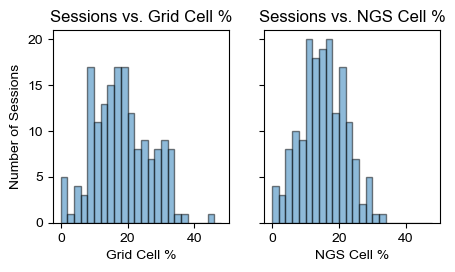

In [20]:
''' Examine grid & NGS cell densities quickly as a sanity check at lower thresholds '''

# Assess distribution of grid/ngs cell densities
print('Mean, SEM Grid Cell %; Mean, Sem NGS Cell %')
print(np.mean(pergrid), stats.sem(pergrid), np.mean(perngs), stats.sem(perngs))

#plot grid vs. ngs cell % distributions
fig, ax = plt.subplots(1,2,figsize = (5,2.5), sharey = True)
ax[0].hist(pergrid, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[0].set_title('Sessions vs. Grid Cell %')
ax[0].set_ylabel('Number of Sessions')
ax[0].set_xlabel('Grid Cell %')

ax[1].hist(perngs, bins = np.arange(0,50,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax[1].set_title('Sessions vs. NGS Cell %')
ax[1].set_xlabel('NGS Cell %')

plt.show()

In [21]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[ma_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[ma_ind]), len(mice[age_ind]))
print(len(y_sind), len(ma_sind), len(age_sind))
Nold = len(mice[age_ind])
Nma = len(mice[ma_ind])
Nyoung = len(mice[y_ind])

['Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26' 'Y27' 'Y28'] ['MA10F' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F'] ['A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A22' 'A23' 'A24']
9 10 10
54 58 55


In [22]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,10)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,9)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in SM_aged_mice:
            idx = np.where(mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in SM_MA_mice:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - (Nold + Nma)
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', "",
              'MA10F', 'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F',
              'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# set up handles
from itertools import repeat
per99 = [mpergrid[y_ind], mpergrid[ma_ind], mpergrid[age_ind]]
handles = []

for i in range(len(per99)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        
        if c[0] == col_animal[0][0][8][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.append(l)

# Grid Cell Stability & Similarity Ratio (Reviewer Figures 6A-D)

Mimics Figures 2f - i at lower threshold

In [23]:
''' Compute & Plot Sorted Cross-Trial Correlation Matrices for Grid Cells; Save Matrices for Later Use 

Run time is a few minutes per session (scales w/ grid cell number).

'''
for m, session in zip(mice,sessions):

    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]    
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)
        
        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(gridcells)))
        for i, c in enumerate(gridcells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
            sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 
            allsim[:,:,i] = sim
            
        # save matrix of cross-trial correlations
        d['allgridsim'] = allsim

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [24]:
''' Calculate Local Cross Trial Correlation Stability within Each Context'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

slocstab5block = []
slocstab5alt = []
max_k = 5

#cell arrays
ylocstab5block = []
ylocstab5alt = []

malocstab5block = []
malocstab5alt = []

alocstab5block = []
alocstab5alt = []

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]   
        
        trial = behaviorfil[:,2]
        
        #load the context lengths, exclude A' and B' gain change trials
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        
        allgridsim = d['allgridsim']
        
        local_stabilityblock = [] 
        local_stabilityalt = []
        for i, c in enumerate(gridcells):
            
            #divide sim by context
            sim = allgridsim[:,:,i]
            simblock = sim[:(lengthA + lengthB),:(lengthA + lengthB)]
            simalt = sim[(lengthA + lengthB):,(lengthA + lengthB):]
       
            #Block Stability
            max_k = 5  
            sum_k = np.zeros(simblock.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simblock, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simblock, offset=k)
            local_stabilityblock = np.append(local_stabilityblock, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
            #Alt Stability
            max_k = 5  
            sum_k = np.zeros(simalt.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simalt, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simalt, offset=k)
            local_stabilityalt = np.append(local_stabilityalt, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
        #save session results
        slocstab5block = np.append(slocstab5block, np.nanmean(local_stabilityblock))
        slocstab5alt = np.append(slocstab5alt, np.nanmean(local_stabilityalt))
        
        #pool by age group
        if m in SM_aged_mice:
            alocstab5block = np.append(alocstab5block, local_stabilityblock) 
            alocstab5alt = np.append(alocstab5alt, local_stabilityalt) 
        elif m in SM_MA_mice:
            malocstab5block = np.append(malocstab5block, local_stabilityblock) 
            malocstab5alt = np.append(malocstab5alt, local_stabilityalt) 
        else:
            ylocstab5block = np.append(ylocstab5block, local_stabilityblock) 
            ylocstab5alt = np.append(ylocstab5alt, local_stabilityalt) 

#save arrays
slocstab5block = np.asarray(slocstab5block)
slocstab5alt = np.asarray(slocstab5alt)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_19996\2972006257.py:79: RuntimeWarning: Mean of empty slice
  slocstab5block = np.append(slocstab5block, np.nanmean(local_stabilityblock))
C:\Users\Python\AppData\Local\Temp\ipykernel_19996\2972006257.py:80: RuntimeWarning: Mean of empty slice
  slocstab5alt = np.append(slocstab5alt, np.nanmean(local_stabilityalt))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Grid Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]
        
        for j, c in enumerate(gridcells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   locstab5block
No. Observations:     8022      Method:               REML         
No. Groups:           29        Scale:                0.0143       
Min. group size:      88        Log-Likelihood:       2282.5418    
Max. group size:      506       Converged:            Yes          
Mean group size:      276.6                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.323    0.036  8.982 0.000  0.253  0.394
C(AgeGroup)[T.2.0]       -0.098    0.055 -1.790 0.073 -0.204  0.009
C(AgeGroup)[T.3.0]        0.007    0.043  0.160 0.873 -0.078  0.091
C(Sex)[T.M]               0.030    0.057  0.524 0.601 -0.082  0.142
C(Cohort)[T.D]           -0.020    0.071 -0.276 0.783 -0.158  0

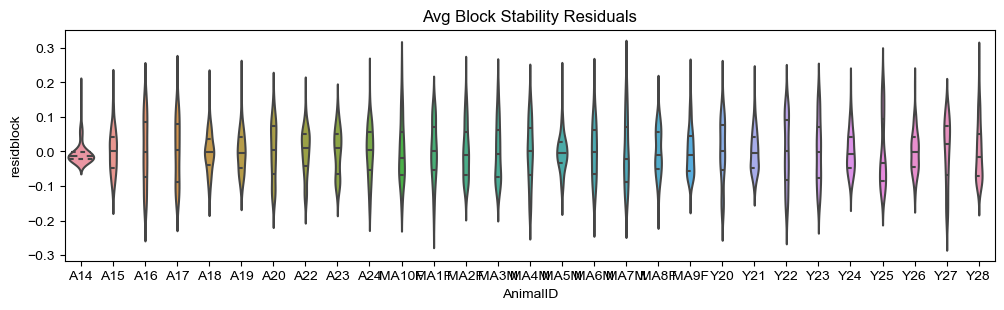

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    locstab5alt
No. Observations:     8022       Method:                REML       
No. Groups:           29         Scale:                 0.0065     
Min. group size:      88         Log-Likelihood:        5453.4517  
Max. group size:      506        Converged:             Yes        
Mean group size:      276.6                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.133    0.025  5.359 0.000  0.085  0.182
C(AgeGroup)[T.2.0]       -0.061    0.038 -1.616 0.106 -0.135  0.013
C(AgeGroup)[T.3.0]        0.046    0.030  1.539 0.124 -0.013  0.104
C(Sex)[T.M]               0.035    0.040  0.896 0.370 -0.042  0.113
C(Cohort)[T.D]           -0.024    0.049 -0.496 0.620 -0.120  0

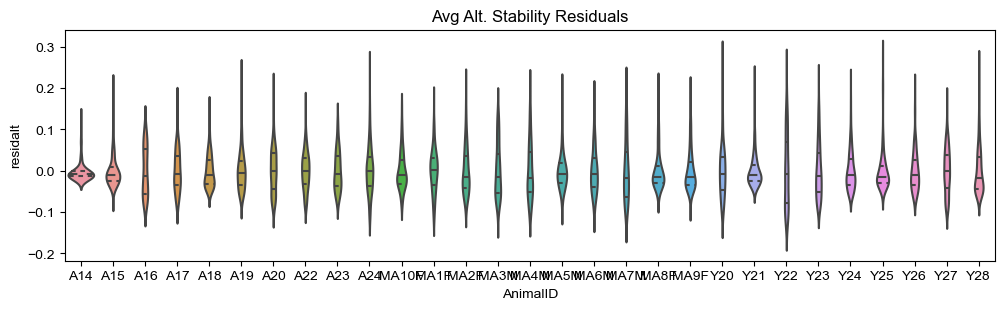

In [26]:
''' LMMs for Moving Avg Similarity [Stability] '''        
#gather dependent variables into lists
locstab5block = list(np.concatenate((alocstab5block, malocstab5block, ylocstab5block)))
locstab5alt = list(np.concatenate((alocstab5alt, malocstab5alt, ylocstab5alt)))
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort,locstab5block,locstab5alt))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','locstab5block','locstab5alt'])

#handle NaNs
df = df.dropna(axis = 0)

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('locstab5block ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block Stability Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('locstab5alt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt. Stability Residuals')
plt.show()


In [27]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 8

n aged, MA, young mice on day 1 for B
10 10 8

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
9 10 9

n aged, MA, young mice on day 3 for B
9 10 9

n aged, MA, young mice on day 4 for A
9 9 9

n aged, MA, young mice on day 4 for B
9 9 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
7 9 9

n aged, MA, young mice on day 6 for B
7 9 9


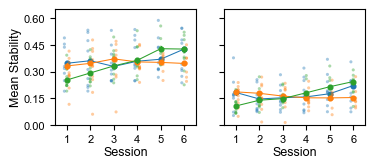

In [28]:
''' Plot Reviewer Figure 6A '''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.15,0.3,0.45,0.6])
ax[0].set_ylim([0.0,0.65])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Stability', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
#ax[1].set_yticks([0,0.15,0.3,0.45,0.6])
#ax[1].set_ylim([0.0,0.6])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
#ax[1].set_ylabel('Stability', fontsize=9, labelpad=1)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot LMM-fitted session average data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure6A.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure6A.svg', dpi=400, bbox_inches='tight')
plt.show()

In [29]:
''' Find where I will have NaNs'''
nan_idxgrid = np.where((spergrid == 0))[0]
nan_idxngs = np.where((sperngs == 0))[0]
print(nan_idxgrid, nan_idxngs)
print(len(col_session[0]),len(col_session[1]),len(col_session[2]))

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindgrid = np.setdiff1d(y_sind, nan_idxgrid)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idxgrid)
age_sindgrid = np.setdiff1d(age_sind, nan_idxgrid)

y_sindngs = np.setdiff1d(y_sind, nan_idxngs)
ma_sindngs = np.setdiff1d(ma_sind, nan_idxngs)
age_sindngs = np.setdiff1d(age_sind, nan_idxngs)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idxgrid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid] 

# Adjust colormaps for ngs plots
yidx = []
maidx = []
aidx = []
for i in nan_idxngs:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))

col_session_youngngs = np.delete(col_session_young, list(yidx), axis = 0)
col_session_mangs = np.delete(col_session_MA, list(maidx), axis = 0)
col_session_oldngs = np.delete(col_session_old, list(aidx), axis = 0)
col_sessionngs = [col_session_youngngs, col_session_mangs, col_session_oldngs] 

print(len(col_session_younggrid),len(col_session_youngngs))
print(len(col_session_magrid),len(col_session_mangs))
print(len(col_session_oldgrid),len(col_session_oldngs))

# This will fix session stats & box plots are plotted.

[ 11  24 110 143] []
54 58 55
53 54
57 58
53 55



Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.14387859322714006 0.5985140360179835 0.6572235404188784 0.4804738597073246
P [Young, MA, Aged, All]: 
0.3040273647840327 8.772079581832069e-07 9.018026689722628e-08 8.538278223852442e-11

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.10474645859479231 0.6510457169229585 0.41722893765772007 0.4061348694153226
P [Young, MA, Aged, All]: 
0.4554022004180901 4.176982503608907e-08 0.0018827315427049083 7.492723972364067e-08

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.3790221843695428 0.6554845040859137 0.7207385753532131 0.581314907870872
P [Young, MA, Aged, All]: 
6.160987281288727e-05 2.502513114625307e-15 3.0243577617731763e-18 7.346805492414767e-31

n session halves: young, ma, aged
106 114 106


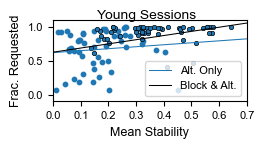

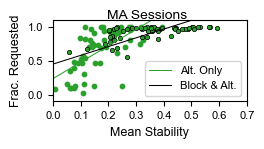

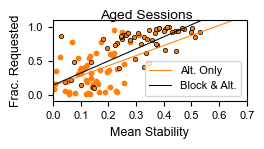

In [30]:
''' Plot Reviewer Figure 6C with Block & Alt. Data '''
allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))

#Linear regression with block data only
res = stats.linregress(slocstab5block[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5block[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5block[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5block[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(slocstab5alt[y_sindgrid],reqalt_rates[y_sindgrid])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindgrid],reqalt_rates[ma_sindgrid])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindgrid],reqalt_rates[age_sindgrid])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(slocstab5alt[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((slocstab5block[y_sindgrid],slocstab5alt[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[ma_sindgrid],slocstab5alt[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[age_sindgrid],slocstab5alt[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid)*2,len(ma_sindgrid)*2,len(age_sindgrid)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(slocstab5alt[y_sindgrid],reqalt_rates[y_sindgrid], color = 'C0', s = 10)
ax.scatter(slocstab5block[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure6Cleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6Cleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(slocstab5alt[ma_sindgrid],reqalt_rates[ma_sindgrid], color = 'C2', s = 10)
ax.scatter(slocstab5block[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure6Cmiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6Cmiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(slocstab5alt[age_sindgrid],reqalt_rates[age_sindgrid], color = 'C1', s = 10)
ax.scatter(slocstab5block[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,0.7])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'ReviewerFigure6Cright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6Cright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [31]:
''' Find Context Match / Mismatch Similarity Ratio '''

sABratio = []
sA_B_ratio = []
sAB_ratio = []

yABratio = []
yA_B_ratio = []
yAB_ratio = []
maABratio = []
maA_B_ratio = []
maAB_ratio = []
aABratio = []
aA_B_ratio = []
aAB_ratio = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        gridcell = d['gridcell'].astype(bool)
        gridcells = cell_IDs[gridcell]     
        trial = behaviorfil[:,2]
        
        #save the context lengths
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        nB = lengthA + lengthB
        nA_ = lengthA + lengthB + lengthA_
        na_ = lengthA + lengthB + lengtha_
        nB_ = lengthA + lengthB + lengtha_ + lengthB_
        
        allgridsim = d['allgridsim']
        ABratio = []
        A_B_ratio = []
        AB_ratio = []
        for i, c in enumerate(gridcells):
            sim = allgridsim[:,:,i]
            sim = (sim - np.min(sim)) / (np.max(sim) - np.min(sim))
            
            #average block context-matched (A x A + B x A), average block context-mismatched (B x A)
            sumcm = (np.sum(sim[:lengthA, :lengthA]) - lengthA)/2 + (np.sum(sim[lengthA:nB, lengthA:nB]) - lengthB)/2
            meancm = sumcm  / ((lengthA**2 - lengthA)/2 + (lengthB**2 - lengthB)/2)
            meancmm = np.average(sim[lengthA:nB,:lengthA])
            if (meancmm != 0): 
                ABratio = np.append(ABratio, meancm / meancmm)
            else: 
                ABratio = np.append(ABratio, np.nan)
            
            #alt context-matched (A' x A' + B' x B'), alt context-mismatched (B' x A')
            sumcm = (np.sum(sim[nB:nA_, nB:nA_]) - lengthA_)/2 + (np.sum(sim[na_:nB_, na_:nB_]) - lengthB_)/2
            meancm = sumcm  / ((lengthA_**2 - lengthA_)/2 + (lengthB_**2 - lengthB_)/2)
            meancmm = np.average(sim[na_:nB_,nB:nA_])
            if (meancmm != 0):
                A_B_ratio = np.append(A_B_ratio, meancm / meancmm)
            else:
                A_B_ratio = np.append(A_B_ratio, np.nan)
            
            #alt context-matched (A' x A + B' x B) & alt context-mismatched (B' x A + A' x B)
            meancm = np.mean(np.concatenate((sim[nB:nA_,:lengthA].flatten(), sim[na_:nB_,lengthA:nB].flatten())))
            meancmm = np.mean(np.concatenate((sim[na_:nB_,:lengthA].flatten(), sim[nB:nA_,lengthA:nB].flatten())))
            if (meancmm != 0):
                AB_ratio = np.append(AB_ratio, meancm / meancmm)
            else:
                AB_ratio = np.append(AB_ratio, np.nan)
        
        sABratio= np.append(sABratio, np.nanmean(ABratio))
        sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
        sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))

        if m in SM_aged_mice:
            aABratio = np.append(aABratio, ABratio)
            aA_B_ratio = np.append(aA_B_ratio, A_B_ratio)
            aAB_ratio = np.append(aAB_ratio, AB_ratio)
        elif m in SM_MA_mice:
            maABratio = np.append(maABratio, ABratio)
            maA_B_ratio = np.append(maA_B_ratio, A_B_ratio)
            maAB_ratio = np.append(maAB_ratio, AB_ratio)
        else:
            yABratio = np.append(yABratio, ABratio)
            yA_B_ratio = np.append(yA_B_ratio, A_B_ratio)
            yAB_ratio = np.append(yAB_ratio, AB_ratio)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_19996\1002897121.py:83: RuntimeWarning: Mean of empty slice
  sABratio= np.append(sABratio, np.nanmean(ABratio))
C:\Users\Python\AppData\Local\Temp\ipykernel_19996\1002897121.py:84: RuntimeWarning: Mean of empty slice
  sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
C:\Users\Python\AppData\Local\Temp\ipykernel_19996\1002897121.py:85: RuntimeWarning: Mean of empty slice
  sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     ABratio  
No. Observations:     8022        Method:                 REML     
No. Groups:           29          Scale:                  0.0312   
Min. group size:      88          Log-Likelihood:         -976.3702
Max. group size:      506         Converged:              Yes      
Mean group size:      276.6                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.183    0.048 24.489 0.000  1.088  1.277
C(AgeGroup)[T.2.0]       -0.086    0.073 -1.170 0.242 -0.229  0.058
C(AgeGroup)[T.3.0]        0.053    0.058  0.910 0.363 -0.061  0.167
C(Sex)[T.M]              -0.032    0.076 -0.424 0.671 -0.182  0.117
C(Cohort)[T.D]            0.057    0.095  0.605 0.545 -0.128  0

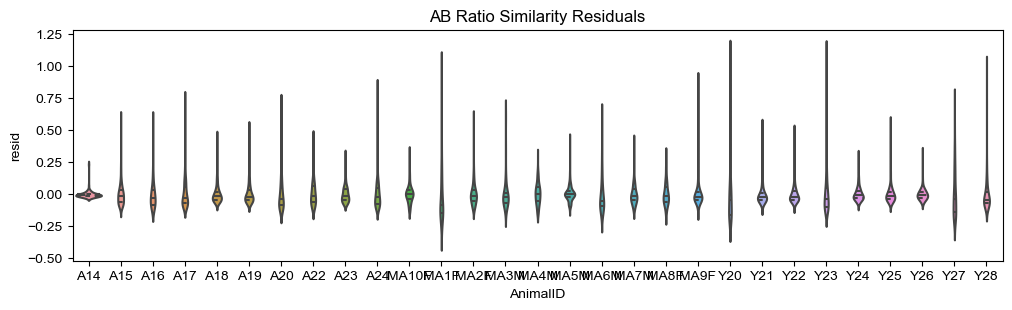

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    A_B_ratio 
No. Observations:      8022       Method:                REML      
No. Groups:            29         Scale:                 0.0018    
Min. group size:       88         Log-Likelihood:        10323.7295
Max. group size:       506        Converged:             Yes       
Mean group size:       276.6                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.003    0.011 87.765 0.000  0.980  1.025
C(AgeGroup)[T.2.0]        0.001    0.017  0.078 0.938 -0.033  0.035
C(AgeGroup)[T.3.0]        0.049    0.014  3.564 0.000  0.022  0.076
C(Sex)[T.M]              -0.001    0.018 -0.031 0.976 -0.036  0.035
C(Cohort)[T.D]            0.015    0.022  0.692 0.489 -0.028  0

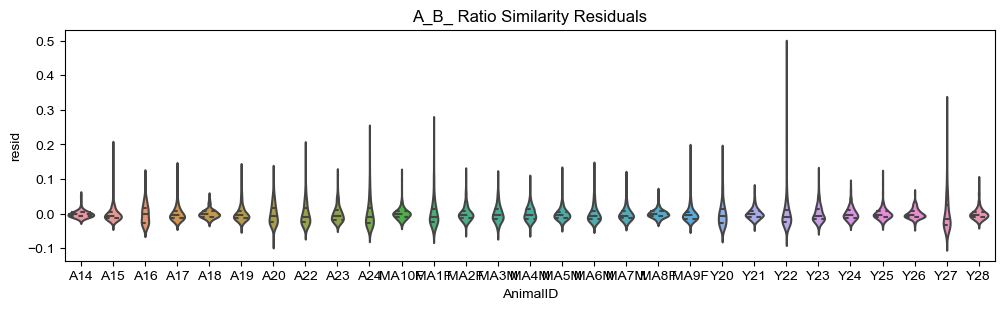

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     AB_ratio 
No. Observations:     8022        Method:                 REML     
No. Groups:           29          Scale:                  0.0025   
Min. group size:      88          Log-Likelihood:         8922.4062
Max. group size:      506         Converged:              Yes      
Mean group size:      276.6                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.005    0.011 89.584 0.000  0.983  1.027
C(AgeGroup)[T.2.0]        0.011    0.017  0.647 0.517 -0.022  0.044
C(AgeGroup)[T.3.0]        0.031    0.014  2.276 0.023  0.004  0.058
C(Sex)[T.M]              -0.011    0.018 -0.648 0.517 -0.046  0.023
C(Cohort)[T.D]            0.008    0.022  0.374 0.709 -0.034  0

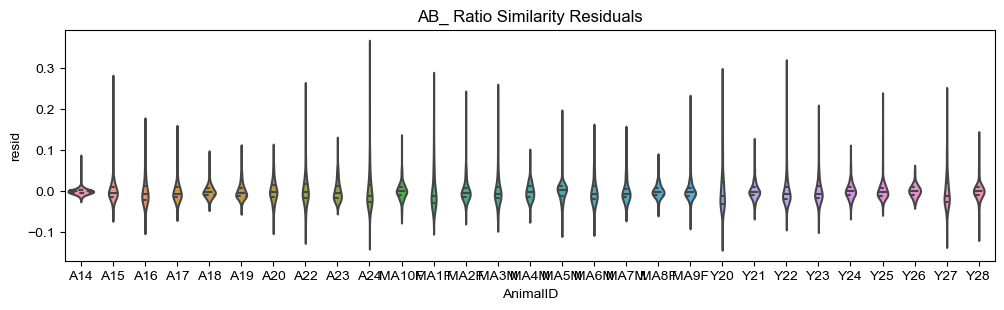

In [32]:
''' LMMs for Similarity Ratios '''        
#gather dependent variables into lists
ABratio = list(np.concatenate((aABratio, maABratio, yABratio)))
A_B_ratio = list(np.concatenate((aA_B_ratio, maA_B_ratio, yA_B_ratio)))
AB_ratio = list(np.concatenate((aAB_ratio, maAB_ratio, yAB_ratio)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, ABratio, A_B_ratio, AB_ratio))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','ABratio','A_B_ratio','AB_ratio'])

#handle NaNs
df = df.dropna(axis = 0)

# ABratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB = smf.mixedlm('ABratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB.summary())
print(mAB.wald_test_terms(scalar = False))

#plot residuals
df['resid'] = mAB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB Ratio Similarity Residuals')
plt.show()

# A_B_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_B_ = smf.mixedlm('A_B_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_B_.summary())
print(mA_B_.wald_test_terms(scalar = False))

df['resid'] = mA_B_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('A_B_ Ratio Similarity Residuals')
plt.show()

# AB_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB_ = smf.mixedlm('AB_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB_.summary())
print(mAB_.wald_test_terms(scalar = False))

df['resid'] = mAB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB_ Ratio Similarity Residuals')
plt.show()

In [33]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mABfitted'] = mAB.fittedvalues
df['mAB_fitted'] = mAB_.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mABfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mABfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAB_fitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['mAB_fitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for block ratio
10 10 8

n aged, MA, young mice on day 1 for alt ratio
10 10 8

n aged, MA, young mice on day 2 for block ratio
10 10 9

n aged, MA, young mice on day 2 for alt ratio
10 10 9

n aged, MA, young mice on day 3 for block ratio
9 10 9

n aged, MA, young mice on day 3 for alt ratio
9 10 9

n aged, MA, young mice on day 4 for block ratio
9 9 9

n aged, MA, young mice on day 4 for alt ratio
9 9 9

n aged, MA, young mice on day 5 for block ratio
8 9 9

n aged, MA, young mice on day 5 for alt ratio
8 9 9

n aged, MA, young mice on day 6 for block ratio
7 9 9

n aged, MA, young mice on day 6 for alt ratio
7 9 9


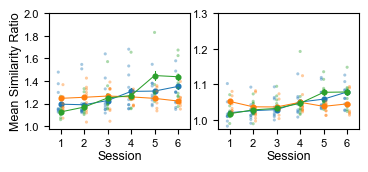

In [34]:
'''Plot Reviewer Figure 6B '''

f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = False)

g = sns.pointplot(x = df['Session'], y = mAB.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([1,1.2,1.4,1.6,1.8,2])
ax[0].set_ylim([0.975,2])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Similarity Ratio', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mAB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([1,1.1,1.2,1.3])
ax[1].set_ylim([0.975,1.3])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for block ratio')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for alt ratio')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure6B.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure6B.svg', dpi=400, bbox_inches='tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.2891886017664681 0.45194240601644015 0.597207316637335 0.4147508900687554
P [Young, MA, Aged, All]: 
0.035708797563642446 0.00041699570241841085 2.352132408250855e-06 3.70452432736153e-08

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4729853599890762 0.4573085473726511 0.43518535913272455 0.45118575386785464
P [Young, MA, Aged, All]: 
0.00034816030680852046 0.0003485167500912679 0.0011275055259657918 1.4999378795471066e-09

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.4690598809344084 0.4759020033576746 0.7013439315711806 0.5209813826953348
P [Young, MA, Aged, All]: 
3.945311406859841e-07 8.729610961877024e-08 5.65473721708393e-17 4.4377587144726016e-24

n session halves: young, ma, aged
106 114 106


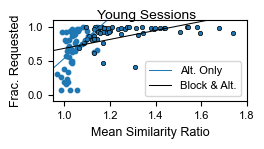

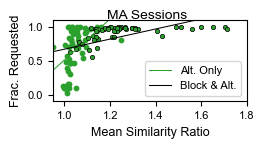

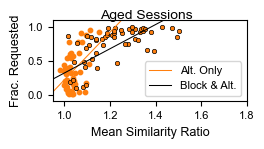

In [35]:
''' Plot Reviewer Figure 6D with Block Data '''

#Linear regression with block data only
res = stats.linregress(sABratio[y_sindgrid],reqblock_rates[y_sindgrid])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sABratio[ma_sindgrid],reqblock_rates[ma_sindgrid])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue; map1 = res.pvalue

res = stats.linregress(sABratio[age_sindgrid],reqblock_rates[age_sindgrid])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue; ap1 = res.pvalue

res = stats.linregress(sABratio[~np.isnan(sABratio)],reqblock_rates[~np.isnan(sABratio)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sAB_ratio[y_sindgrid],reqalt_rates[y_sindgrid])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindgrid],reqalt_rates[ma_sindgrid])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindgrid],reqalt_rates[age_sindgrid])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sAB_ratio[~np.isnan(sAB_ratio)],reqalt_rates[~np.isnan(sAB_ratio)])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sABratio[y_sindgrid],sAB_ratio[y_sindgrid])),np.hstack((reqblock_rates[y_sindgrid],reqalt_rates[y_sindgrid])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[ma_sindgrid],sAB_ratio[ma_sindgrid])),np.hstack((reqblock_rates[ma_sindgrid],reqalt_rates[ma_sindgrid])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[age_sindgrid],sAB_ratio[age_sindgrid])),np.hstack((reqblock_rates[age_sindgrid],reqalt_rates[age_sindgrid])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

allidx = np.concatenate((y_sindgrid, ma_sindgrid, age_sindgrid))
res = stats.linregress(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindgrid)*2,len(ma_sindgrid)*2,len(age_sindgrid)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sAB_ratio[y_sindgrid],reqalt_rates[y_sindgrid], color = 'C0', s = 10)
ax.scatter(sABratio[y_sindgrid],reqblock_rates[y_sindgrid], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure6Dleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6Dleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sAB_ratio[ma_sindgrid],reqalt_rates[ma_sindgrid], color = 'C2', s = 10)
ax.scatter(sABratio[ma_sindgrid],reqblock_rates[ma_sindgrid], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure6Dmiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6Dmiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sAB_ratio[age_sindgrid],reqalt_rates[age_sindgrid], color = 'C1', s = 10)
ax.scatter(sABratio[age_sindgrid],reqblock_rates[age_sindgrid], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.8])
ax.set_xticks([1,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'ReviewerFigure6Dright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6Dright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

# NGS Cell Stability & Similarity Ratio (Plot Reviewer Figure 6E-H)

Mimics Figures S3F-I at lower thresholds. 

In [36]:
''' Compute & Plot Sorted Cross-Trial Correlation Matrices for NGS Cells.

Run time is a few minutes per session (scales w/ NGS cell number).

'''

for m, session in zip(mice,sessions):

    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]    
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            skippedtrials = get.find_skipped(trial, max_trial_num = 220)
            
        except:
            skippedtrials = []
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        # Sort trials by context, find sorted skipped trials, num dark skipped trials
        leftsort, allcopy = get.contextsortedtrials(alltrial, left, alt_idx = 140)
        
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #adjust trialfil so that sorted trials are skipped instead
        skippedrawtrialfil = get.sortedtrialbyframe(rawtrialfil, trial, newskippedtrials)
        numtrial = np.unique(skippedrawtrialfil)

        #sort spike train & position on VR frames by context during alternation
        posxcopy = []
        allcopy= np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])
            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)
        
        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = ps.tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
    
        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(ngscells)))
        for i, c in enumerate(ngscells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
            sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 
            allsim[:,:,i] = sim
            
        # save matrix of cross-trial correlations
        d['allngssim'] = allsim

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [37]:
''' Calculate Local Cross Trial Correlation Stability within Each Context & for Block vs. Alt Phases'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

#adjust loading folder path to match output of cell above
slocstab5block = []
slocstab5alt = []
max_k = 5

#cell arrays
ylocstab5block = []
ylocstab5alt = []

malocstab5block = []
malocstab5alt = []

alocstab5block = []
alocstab5alt = []

for m, session in zip(mice, sessions):
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]     
        trial = behaviorfil[:,2]
        
        #load the context lengths, exclude A' and B' gain change trials
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        
        allsim = d['allngssim']
    
        local_stabilityblock = [] 
        local_stabilityalt = []
        
        for i, c in enumerate(ngscells):
            
            #divide sim by context
            sim = allsim[:,:,i]
            simblock = sim[:(lengthA + lengthB),:(lengthA + lengthB)]
            simalt = sim[(lengthA + lengthB):,(lengthA + lengthB):]
            
            #Block Stability
            max_k = 5  
            sum_k = np.zeros(simblock.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simblock, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simblock, offset=k)
            local_stabilityblock = np.append(local_stabilityblock, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
            #Alt Stability
            max_k = 5  
            sum_k = np.zeros(simalt.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simalt, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simalt, offset=k)
            local_stabilityalt = np.append(local_stabilityalt, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
        
        #save session results
        slocstab5block = np.append(slocstab5block, np.nanmean(local_stabilityblock))
        slocstab5alt = np.append(slocstab5alt, np.nanmean(local_stabilityalt))
        
        #pool by age group
        if m in SM_aged_mice:
            alocstab5block = np.append(alocstab5block, local_stabilityblock) 
            alocstab5alt = np.append(alocstab5alt, local_stabilityalt) 
        elif m in SM_MA_mice:
            malocstab5block = np.append(malocstab5block, local_stabilityblock) 
            malocstab5alt = np.append(malocstab5alt, local_stabilityalt) 
        else:
            ylocstab5block = np.append(ylocstab5block, local_stabilityblock) 
            ylocstab5alt = np.append(ylocstab5alt, local_stabilityalt) 
        
#save arrays
slocstab5block = np.asarray(slocstab5block)
slocstab5alt = np.asarray(slocstab5alt)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [38]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each NGS Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]
        
        for j, c in enumerate(ngscells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   locstab5block
No. Observations:     6662      Method:               REML         
No. Groups:           29        Scale:                0.0115       
Min. group size:      74        Log-Likelihood:       2069.3474    
Max. group size:      427       Converged:            Yes          
Mean group size:      229.7                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.227    0.019 11.678 0.000  0.189  0.265
C(AgeGroup)[T.2.0]       -0.025    0.029 -0.874 0.382 -0.082  0.031
C(AgeGroup)[T.3.0]        0.050    0.024  2.080 0.038  0.003  0.097
C(Sex)[T.M]               0.032    0.029  1.114 0.265 -0.024  0.088
C(Cohort)[T.D]           -0.025    0.036 -0.688 0.491 -0.094  0

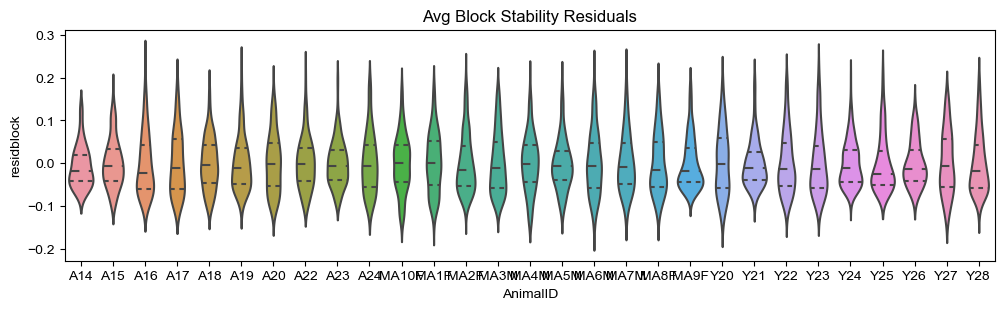

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    locstab5alt
No. Observations:     6662       Method:                REML       
No. Groups:           29         Scale:                 0.0064     
Min. group size:      74         Log-Likelihood:        4101.4272  
Max. group size:      427        Converged:             Yes        
Mean group size:      229.7                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.103    0.016  6.588 0.000  0.073  0.134
C(AgeGroup)[T.2.0]       -0.024    0.023 -1.006 0.314 -0.070  0.022
C(AgeGroup)[T.3.0]        0.049    0.019  2.552 0.011  0.011  0.087
C(Sex)[T.M]               0.019    0.024  0.791 0.429 -0.028  0.065
C(Cohort)[T.D]           -0.004    0.029 -0.125 0.900 -0.061  0

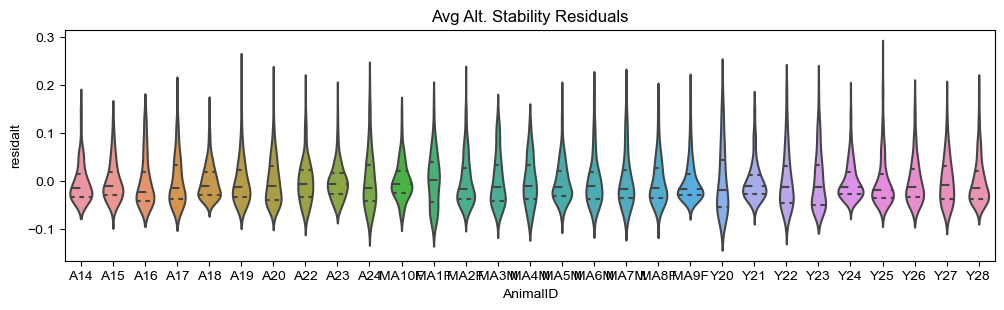

In [39]:
''' LMMs for NGS Cell Moving Avg Similarity [Stability] '''        
#gather dependent variables into lists
locstab5block = list(np.concatenate((alocstab5block, malocstab5block, ylocstab5block)))
locstab5alt = list(np.concatenate((alocstab5alt, malocstab5alt, ylocstab5alt)))
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, locstab5block,locstab5alt))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','locstab5block','locstab5alt'])

#handle NaNs
df = df.dropna(axis = 0)

#Block Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mblock = smf.mixedlm('locstab5block ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mblock.summary())
print(mblock.wald_test_terms(scalar = False))

df['residblock'] = mblock.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residblock', inner = 'quartile', ax = ax)
plt.title('Avg Block Stability Residuals')
plt.show()

#Alt Dependent
vc = {'cells':'0 + C(Cell_ID)'}
malt = smf.mixedlm('locstab5alt ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(malt.summary())
print(malt.wald_test_terms(scalar = False))

df['residalt'] = malt.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residalt', inner = 'quartile', ax = ax)
plt.title('Avg Alt. Stability Residuals')
plt.show()


In [40]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mblockfitted'] = mblock.fittedvalues
df['maltfitted'] = malt.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mblockfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mblockfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['maltfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['maltfitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A
10 10 9

n aged, MA, young mice on day 1 for B
10 10 9

n aged, MA, young mice on day 2 for A
10 10 9

n aged, MA, young mice on day 2 for B
10 10 9

n aged, MA, young mice on day 3 for A
10 10 9

n aged, MA, young mice on day 3 for B
10 10 9

n aged, MA, young mice on day 4 for A
9 10 9

n aged, MA, young mice on day 4 for B
9 10 9

n aged, MA, young mice on day 5 for A
8 9 9

n aged, MA, young mice on day 5 for B
8 9 9

n aged, MA, young mice on day 6 for A
8 9 9

n aged, MA, young mice on day 6 for B
8 9 9


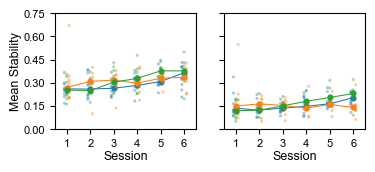

In [41]:
''' Plot Reviewer Figure 6E'''
f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mblock.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([0,0.15,0.3,0.45,0.6,0.75])
ax[0].set_ylim([0.0,0.75])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Stability', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = malt.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.15,0.3,0.45,0.6,0.75])
ax[1].set_ylim([0.0,0.75])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
#ax[1].set_ylabel('Stability', fontsize=9, labelpad=1)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure6E.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure6E.svg', dpi=400, bbox_inches='tight')
plt.show()

In [42]:
''' Find where I will have NaNs'''
nan_idxgrid = np.where((spergrid == 0))[0]
nan_idxngs = np.where((sperngs == 0))[0]
print(nan_idxgrid, nan_idxngs)
print(len(col_session[0]),len(col_session[1]),len(col_session[2]))

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindgrid = np.setdiff1d(y_sind, nan_idxgrid)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idxgrid)
age_sindgrid = np.setdiff1d(age_sind, nan_idxgrid)

y_sindngs = np.setdiff1d(y_sind, nan_idxngs)
ma_sindngs = np.setdiff1d(ma_sind, nan_idxngs)
age_sindngs = np.setdiff1d(age_sind, nan_idxngs)

# Adjust colormaps for grid plots
yidx = []
maidx = []
aidx = []
for i in nan_idxgrid:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int)) 

col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid] 

# Adjust colormaps for ngs plots
yidx = []
maidx = []
aidx = []
for i in nan_idxngs:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(y_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))

col_session_youngngs = np.delete(col_session_young, list(yidx), axis = 0)
col_session_mangs = np.delete(col_session_MA, list(maidx), axis = 0)
col_session_oldngs = np.delete(col_session_old, list(aidx), axis = 0)
col_sessionngs = [col_session_youngngs, col_session_mangs, col_session_oldngs] 

print(len(col_session_younggrid),len(col_session_youngngs))
print(len(col_session_magrid),len(col_session_mangs))
print(len(col_session_oldgrid),len(col_session_oldngs))

# This will fix session stats & box plots are plotted.

[ 11  24 110 143] []
54 58 55
53 54
57 58
53 55



Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.27937484170588717 0.5950326050362357 0.5272714994079923 0.43446899762414204
P [Young, MA, Aged, All]: 
0.04076878082722563 8.393100058089706e-07 3.532940918739259e-05 4.453634998518465e-09

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.19942485585472786 0.6177724175672445 0.42479151557571165 0.388767059764414
P [Young, MA, Aged, All]: 
0.14824885540366245 2.389879017609622e-07 0.0012268420044852977 2.0810288811815073e-07

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.46250340022343156 0.6413124859255908 0.656177487131741 0.5675174098805638
P [Young, MA, Aged, All]: 
4.671812996426054e-07 8.810264697980045e-15 7.17711137318804e-15 7.251299579004446e-30

n session halves: young, ma, aged
108 116 110


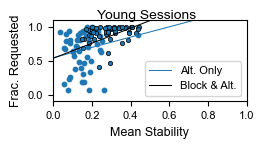

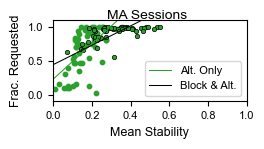

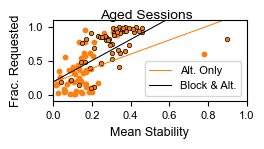

In [43]:
''' Plot Reviewer Figure 6G '''
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.linregress(slocstab5block[y_sindngs],reqblock_rates[y_sindngs])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5block[ma_sindngs],reqblock_rates[ma_sindngs])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5block[age_sindngs],reqblock_rates[age_sindngs])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5block[~np.isnan(slocstab5block)],reqblock_rates[~np.isnan(slocstab5block)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(slocstab5alt[y_sindngs],reqalt_rates[y_sindngs])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindngs],reqalt_rates[ma_sindngs])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindngs],reqalt_rates[age_sindngs])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(slocstab5alt[~np.isnan(slocstab5alt)],reqalt_rates[~np.isnan(slocstab5alt)])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((slocstab5block[y_sindngs],slocstab5alt[y_sindngs])),np.hstack((reqblock_rates[y_sindngs],reqalt_rates[y_sindngs])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[ma_sindngs],slocstab5alt[ma_sindngs])),np.hstack((reqblock_rates[ma_sindngs],reqalt_rates[ma_sindngs])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue ; map3 = res.pvalue

res = stats.linregress(np.hstack((slocstab5block[age_sindngs],slocstab5alt[age_sindngs])),np.hstack((reqblock_rates[age_sindngs],reqalt_rates[age_sindngs])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue ; ap3 = res.pvalue

allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))
res = stats.linregress(np.hstack((slocstab5block[allidx],slocstab5alt[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindngs)*2,len(ma_sindngs)*2,len(age_sindngs)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(slocstab5alt[y_sindngs],reqalt_rates[y_sindngs], color = 'C0', s = 10)
ax.scatter(slocstab5block[y_sindngs],reqblock_rates[y_sindngs], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,1])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure6Gleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6Gleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(slocstab5alt[ma_sindngs],reqalt_rates[ma_sindngs], color = 'C2', s = 10)
ax.scatter(slocstab5block[ma_sindngs],reqblock_rates[ma_sindngs], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,1.0])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure6Gmiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6Gmiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(slocstab5alt[age_sindngs],reqalt_rates[age_sindngs], color = 'C1', s = 10)
ax.scatter(slocstab5block[age_sindngs],reqblock_rates[age_sindngs], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Stability', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0,1])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'ReviewerFigure6Gright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6Gright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [44]:
''' Find Context Match / Mismatch Similarity Ratio '''

sABratio = []
sA_B_ratio = []
sAB_ratio = []

yABratio = []
yA_B_ratio = []
yAB_ratio = []
maABratio = []
maA_B_ratio = []
maAB_ratio = []
aABratio = []
aA_B_ratio = []
aAB_ratio = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        ngscell = d['ngscell'].astype(bool)
        ngscells = cell_IDs[ngscell]     
        trial = behaviorfil[:,2]
        
        #save the context lengths
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        nB = lengthA + lengthB
        nA_ = lengthA + lengthB + lengthA_
        na_ = lengthA + lengthB + lengtha_
        nB_ = lengthA + lengthB + lengtha_ + lengthB_
        
        allngssim = d['allngssim']
        ABratio = []
        A_B_ratio = []
        AB_ratio = []
        for i, c in enumerate(ngscells):
            sim = allngssim[:,:,i]
            sim = (sim - np.min(sim)) / (np.max(sim) - np.min(sim))
            
            #average block context-matched (A x A + B x A), average block context-mismatched (B x A)
            sumcm = (np.sum(sim[:lengthA, :lengthA]) - lengthA)/2 + (np.sum(sim[lengthA:nB, lengthA:nB]) - lengthB)/2
            meancm = sumcm  / ((lengthA**2 - lengthA)/2 + (lengthB**2 - lengthB)/2)
            meancmm = np.average(sim[lengthA:nB,:lengthA])
            if (meancmm != 0): 
                ABratio = np.append(ABratio, meancm / meancmm)
            else: 
                ABratio = np.append(ABratio, np.nan)
            
            #alt context-matched (A' x A' + B' x B'), alt context-mismatched (B' x A')
            sumcm = (np.sum(sim[nB:nA_, nB:nA_]) - lengthA_)/2 + (np.sum(sim[na_:nB_, na_:nB_]) - lengthB_)/2
            meancm = sumcm  / ((lengthA_**2 - lengthA_)/2 + (lengthB_**2 - lengthB_)/2)
            meancmm = np.average(sim[na_:nB_,nB:nA_])
            if (meancmm != 0):
                A_B_ratio = np.append(A_B_ratio, meancm / meancmm)
            else:
                A_B_ratio = np.append(A_B_ratio, np.nan)
            
            #alt context-matched (A' x A + B' x B) & alt context-mismatched (B' x A + A' x B)
            meancm = np.mean(np.concatenate((sim[nB:nA_,:lengthA].flatten(), sim[na_:nB_,lengthA:nB].flatten())))
            meancmm = np.mean(np.concatenate((sim[na_:nB_,:lengthA].flatten(), sim[nB:nA_,lengthA:nB].flatten())))
            if (meancmm != 0):
                AB_ratio = np.append(AB_ratio, meancm / meancmm)
            else:
                AB_ratio = np.append(AB_ratio, np.nan)
        
        sABratio= np.append(sABratio, np.nanmean(ABratio))
        sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
        sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))

        if m in SM_aged_mice:
            aABratio = np.append(aABratio, ABratio)
            aA_B_ratio = np.append(aA_B_ratio, A_B_ratio)
            aAB_ratio = np.append(aAB_ratio, AB_ratio)
        elif m in SM_MA_mice:
            maABratio = np.append(maABratio, ABratio)
            maA_B_ratio = np.append(maA_B_ratio, A_B_ratio)
            maAB_ratio = np.append(maAB_ratio, AB_ratio)
        else:
            yABratio = np.append(yABratio, ABratio)
            yA_B_ratio = np.append(yA_B_ratio, A_B_ratio)
            yAB_ratio = np.append(yAB_ratio, AB_ratio)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     ABratio 
No. Observations:      6662        Method:                 REML    
No. Groups:            29          Scale:                  0.0116  
Min. group size:       74          Log-Likelihood:         812.6517
Max. group size:       427         Converged:              Yes     
Mean group size:       229.7                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.092    0.020 54.846 0.000  1.053  1.131
C(AgeGroup)[T.2.0]        0.013    0.029  0.434 0.664 -0.045  0.071
C(AgeGroup)[T.3.0]        0.056    0.025  2.225 0.026  0.007  0.105
C(Sex)[T.M]              -0.007    0.028 -0.233 0.815 -0.062  0.049
C(Cohort)[T.D]            0.021    0.035  0.608 0.543 -0.048  0

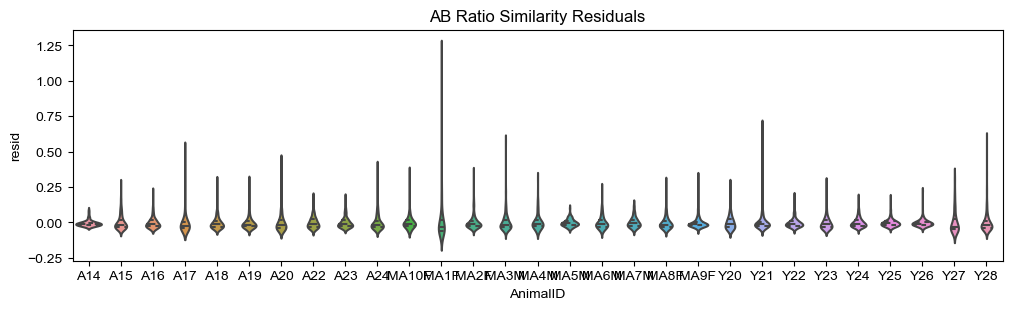

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     A_B_ratio
No. Observations:      6662        Method:                 REML     
No. Groups:            29          Scale:                  0.0008   
Min. group size:       74          Log-Likelihood:         9460.4889
Max. group size:       427         Converged:              No       
Mean group size:       229.7                                        
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 1.008    0.007 143.649 0.000  0.994  1.021
C(AgeGroup)[T.2.0]        0.005    0.010   0.474 0.635 -0.016  0.026
C(AgeGroup)[T.3.0]        0.031    0.009   3.545 0.000  0.014  0.047
C(Sex)[T.M]              -0.004    0.011  -0.391 0.696 -0.025  0.017
C(Cohort)[T.D]            0.012    0.013   0.885 0

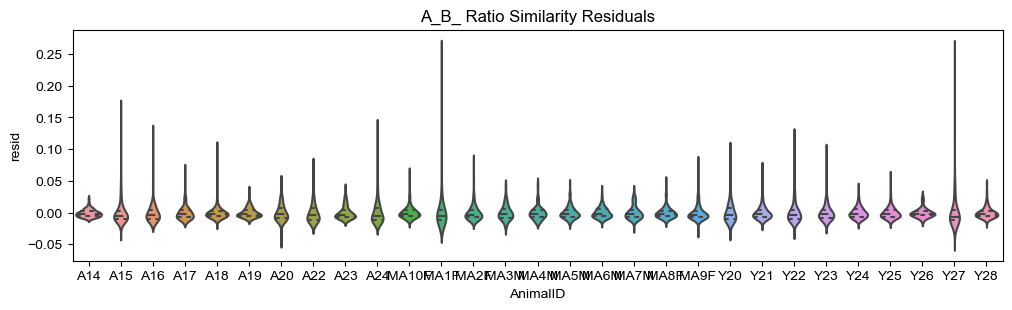

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     AB_ratio 
No. Observations:      6662        Method:                 REML     
No. Groups:            29          Scale:                  0.0011   
Min. group size:       74          Log-Likelihood:         8270.3910
Max. group size:       427         Converged:              Yes      
Mean group size:       229.7                                        
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 1.014    0.008 122.448 0.000  0.998  1.031
C(AgeGroup)[T.2.0]        0.008    0.012   0.680 0.496 -0.016  0.033
C(AgeGroup)[T.3.0]        0.014    0.010   1.375 0.169 -0.006  0.034
C(Sex)[T.M]              -0.007    0.012  -0.598 0.550 -0.032  0.017
C(Cohort)[T.D]            0.004    0.015   0.249 0

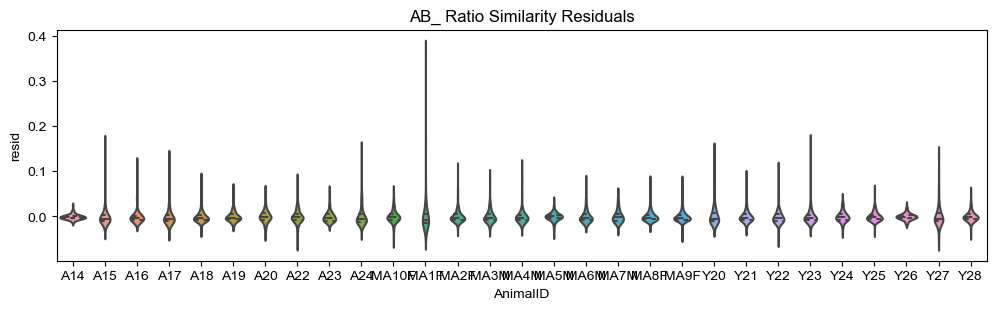

In [45]:
''' LMMs for Similarity Ratios '''        
#gather dependent variables into lists
ABratio = list(np.concatenate((aABratio, maABratio, yABratio)))
A_B_ratio = list(np.concatenate((aA_B_ratio, maA_B_ratio, yA_B_ratio)))
AB_ratio = list(np.concatenate((aAB_ratio, maAB_ratio, yAB_ratio)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, ABratio, A_B_ratio, AB_ratio))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','ABratio','A_B_ratio','AB_ratio'])

#handle NaNs
df = df.dropna(axis = 0)

# ABratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB = smf.mixedlm('ABratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB.summary())
print(mAB.wald_test_terms(scalar = False))

#plot residuals
df['resid'] = mAB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB Ratio Similarity Residuals')
plt.show()

# A_B_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_B_ = smf.mixedlm('A_B_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_B_.summary())
print(mA_B_.wald_test_terms(scalar = False))

df['resid'] = mA_B_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('A_B_ Ratio Similarity Residuals')
plt.show()

# AB_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB_ = smf.mixedlm('AB_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB_.summary())
print(mAB_.wald_test_terms(scalar = False))

df['resid'] = mAB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB_ Ratio Similarity Residuals')
plt.show()

In [46]:
''' Get fitted block vs. alt (not split by epoch) session averages '''

r = 6 #sessions

df['mABfitted'] = mAB.fittedvalues
df['mAB_fitted'] = mAB_.fittedvalues

resultA = df.groupby(by = ['AnimalID','Session'], as_index = False)['mABfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA['AnimalID'])
seshAcount = np.asarray(resultA['Session'])
seshAmean = np.asarray(resultA['mABfitted'])

resultB = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAB_fitted'].aggregate('mean')
seshBanimal = np.asarray(resultB['AnimalID'])
seshBcount = np.asarray(resultB['Session'])
seshBmean = np.asarray(resultB['mAB_fitted'])

slocstab5Afitted_seg_aged = [[] * r for i in range(r)]
slocstab5Afitted_seg_MA = [[] * r for i in range(r)]
slocstab5Afitted_seg_young = [[] * r for i in range(r)]
slocstab5Bfitted_seg_aged = [[] * r for i in range(r)]
slocstab5Bfitted_seg_MA = [[] * r for i in range(r)]
slocstab5Bfitted_seg_young = [[] * r for i in range(r)]

sessionAcountfitted_aged = [[] * r for i in range(r)]
sessionAcountfitted_MA = [[] * r for i in range(r)]
sessionAcountfitted_young = [[] * r for i in range(r)]
sessionBcountfitted_aged = [[] * r for i in range(r)]
sessionBcountfitted_MA = [[] * r for i in range(r)]
sessionBcountfitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_aged[idx] = np.append(slocstab5Afitted_seg_aged[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_aged[idx] = np.append(sessionAcountfitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5Bfitted_seg_aged[idx] = np.append(slocstab5Bfitted_seg_aged[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_aged[idx] = np.append(sessionBcountfitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_MA[idx] = np.append(slocstab5Afitted_seg_MA[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_MA[idx] = np.append(sessionAcountfitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_MA[idx] = np.append(slocstab5Bfitted_seg_MA[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_MA[idx] = np.append(sessionBcountfitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5Afitted_seg_young[idx] = np.append(slocstab5Afitted_seg_young[idx],seshAmean[sessiona_idx][i])
            sessionAcountfitted_young[idx] = np.append(sessionAcountfitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5Bfitted_seg_young[idx] = np.append(slocstab5Bfitted_seg_young[idx],seshBmean[sessionb_idx][i])
            sessionBcountfitted_young[idx] = np.append(sessionBcountfitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for block ratio
10 10 9

n aged, MA, young mice on day 1 for alt ratio
10 10 9

n aged, MA, young mice on day 2 for block ratio
10 10 9

n aged, MA, young mice on day 2 for alt ratio
10 10 9

n aged, MA, young mice on day 3 for block ratio
10 10 9

n aged, MA, young mice on day 3 for alt ratio
10 10 9

n aged, MA, young mice on day 4 for block ratio
9 10 9

n aged, MA, young mice on day 4 for alt ratio
9 10 9

n aged, MA, young mice on day 5 for block ratio
8 9 9

n aged, MA, young mice on day 5 for alt ratio
8 9 9

n aged, MA, young mice on day 6 for block ratio
8 9 9

n aged, MA, young mice on day 6 for alt ratio
8 9 9


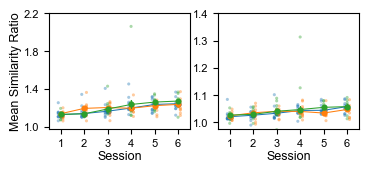

In [47]:
'''Plot Reviewer Figure 6F '''

f, ax = plt.subplots(1, 2, figsize=(4, 1.5), sharey = False)

g = sns.pointplot(x = df['Session'], y = mAB.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[0].set_yticks([1,1.4,1.8,2.2])
ax[0].set_ylim([0.975,2.2])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Similarity Ratio', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mAB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([1,1.1,1.2,1.3,1.4])
ax[1].set_ylim([0.975,1.4])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5Afitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for block ratio')
    print(len(sessionAcountfitted_aged[i]),len(sessionAcountfitted_MA[i]), len(sessionAcountfitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for alt ratio')
    print(len(sessionBcountfitted_aged[i]),len(sessionBcountfitted_MA[i]), len(sessionBcountfitted_young[i]))
    
    ax[0].scatter(sessionAcountfitted_aged[i] + 0.1, slocstab5Afitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_MA[i], slocstab5Afitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcountfitted_young[i] - 0.1, slocstab5Afitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcountfitted_aged[i] + 0.1, slocstab5Bfitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_MA[i], slocstab5Bfitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcountfitted_young[i] - 0.1, slocstab5Bfitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
plt.savefig(save_folder + 'ReviewerFigure6F.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure6F.svg', dpi=400, bbox_inches='tight')
plt.show()


Association btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.3934136696779291 0.38644747911518873 0.6458729434951341 0.40793707817860425
P [Young, MA, Aged, All]: 
0.003250227080154366 0.002732069833186922 1.0101743073418157e-07 4.4487078881950066e-08

Association btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5076892891246366 0.35531334385815805 0.406822977239781 0.3956900628611995
P [Young, MA, Aged, All]: 
8.909086946812069e-05 0.006199974635512004 0.0020541172855994346 1.205498660876689e-07

Association btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5277955050721678 0.4285715945809735 0.7296143860407317 0.5182128805628591
P [Young, MA, Aged, All]: 
4.368043529149488e-09 1.5901723182639238e-06 1.5635124067095928e-19 2.3891713936320764e-24

n session halves: young, ma, aged
108 116 110


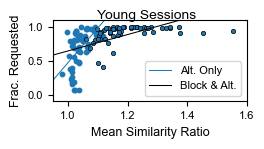

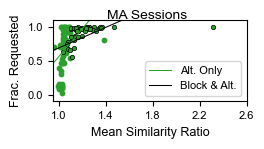

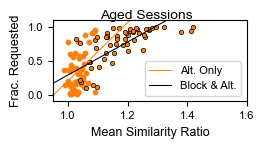

In [48]:
''' Plot Reviewer Figure 6H '''
allidx = np.concatenate((y_sindngs, ma_sindngs, age_sindngs))

#Linear regression with block data only
res = stats.linregress(sABratio[y_sindngs],reqblock_rates[y_sindngs])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sABratio[ma_sindngs],reqblock_rates[ma_sindngs])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sABratio[age_sindngs],reqblock_rates[age_sindngs])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue; ap1 = res.pvalue

res = stats.linregress(sABratio[allidx],reqblock_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

#Linear regression with alt data only
res = stats.linregress(sAB_ratio[y_sindngs],reqalt_rates[y_sindngs])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindngs],reqalt_rates[ma_sindngs])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindngs],reqalt_rates[age_sindngs])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(sAB_ratio[allidx],reqalt_rates[allidx])
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Alt.) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Linear regression with block & alt data together
res = stats.linregress(np.hstack((sABratio[y_sindngs],sAB_ratio[y_sindngs])),np.hstack((reqblock_rates[y_sindngs],reqalt_rates[y_sindngs])))
yslope3 = res.slope; yint3 = res.intercept; yr3 = res.rvalue; yp3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[ma_sindngs],sAB_ratio[ma_sindngs])),np.hstack((reqblock_rates[ma_sindngs],reqalt_rates[ma_sindngs])))
maslope3 = res.slope; maint3 = res.intercept; mar3 = res.rvalue; map3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[age_sindngs],sAB_ratio[age_sindngs])),np.hstack((reqblock_rates[age_sindngs],reqalt_rates[age_sindngs])))
aslope3 = res.slope; aint3 = res.intercept; ar3 = res.rvalue; ap3 = res.pvalue

res = stats.linregress(np.hstack((sABratio[allidx],sAB_ratio[allidx])),np.hstack((reqblock_rates[allidx],reqalt_rates[allidx])))
allslope3 = res.slope; allint3 = res.intercept; allr3 = res.rvalue; allp3 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All (Block + Alt) Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr3, mar3, ar3, allr3)
print('P [Young, MA, Aged, All]: ')
print(yp3, map3, ap3, allp3)

print('\nn session halves: young, ma, aged')
print(len(y_sindngs)*2,len(ma_sindngs)*2,len(age_sindngs)*2)

#Plot Stability over All Sessions by Age Group with Block & Alt Phases
fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Young Sessions', fontsize = 10)
ax.scatter(sAB_ratio[y_sindngs],reqalt_rates[y_sindngs], color = 'C0', s = 10)
ax.scatter(sABratio[y_sindngs],reqblock_rates[y_sindngs], color = 'C0', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.6])
ax.set_xticks([1,1.2,1.4,1.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, yslope2*X_plot + yint2, '-', color = 'C0', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, yslope3*X_plot + yint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure6Hleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6Hleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('MA Sessions', fontsize = 10)
ax.scatter(sAB_ratio[ma_sindngs],reqalt_rates[ma_sindngs], color = 'C2', s = 10)
ax.scatter(sABratio[ma_sindngs],reqblock_rates[ma_sindngs], color = 'C2', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,2.6])
ax.set_xticks([1,1.4,1.8,2.2,2.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, maslope2*X_plot + maint2, '-', color = 'C2', linewidth = 0.75, label = 'Alt. Only')
ax.plot(X_plot, maslope3*X_plot + maint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8)
plt.savefig(save_folder + 'ReviewerFigure6Hmiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6Hmiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

fig, ax = plt.subplots(figsize = (2.5,1.05))
fig.suptitle('Aged Sessions', fontsize = 10)
ax.scatter(sAB_ratio[age_sindngs],reqalt_rates[age_sindngs], color = 'C1', s = 10)
ax.scatter(sABratio[age_sindngs],reqblock_rates[age_sindngs], color = 'C1', s = 10, edgecolor = 'k', lw = 0.5)
ax.set_xlabel('Mean Similarity Ratio', fontsize = 9)
ax.set_ylabel('Frac. Requested', fontsize = 9)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0.95,1.6])
ax.set_xticks([1,1.2,1.4,1.6])
ax.tick_params(labelsize = 8)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
ax.plot(X_plot, aslope2*X_plot + aint2, '-', linewidth = 0.75, color = 'C1', label = 'Alt. Only')
ax.plot(X_plot, aslope3*X_plot + aint3, '-', linewidth = 0.75, color = 'k', label = 'Block & Alt.')
ax.legend(fontsize = 8,)
plt.savefig(save_folder + 'ReviewerFigure6Hright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'ReviewerFigure6Hright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

# Setup for Reviewer Figure 6I-J

In [49]:
'''Define which mice & sessions to load'''
mice = all_mice
sessions = all_sessions
    
# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [50]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

In [51]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,17)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,18)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in all_aged_mice:
            idx = np.where(all_aged_mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in all_MA_mice:
            idx = np.where(all_MA_mice == m)[0][0]
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(all_young_mice == m)[0][0]
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y2','Y3','Y4','Y11','Y16','Y17','Y18','Y19','Y9', 'Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28',
            'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F','MA10F',"","","","","","","",
            'A3','A4','A5','A6','A7','A12','A13','A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# Classify positively and negatively speed-tuned (+ / - speed) cells 

Use lower thresholds of 95th percentile.

In [52]:
''' Calculate & Save Real Speed Scores & Speed Stability Scores '''
realspeedscores = []
realspeedstabscores = []
dt = 0.02
sigma = 20  # smoothing factor for instantaneous firing rate
n_bin = 8 #n position bins considered for speed stability score
track_length = 400 #cm
bins = np.arange(0,track_length + (track_length/n_bin),(track_length/n_bin))

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        posxfil = behaviorfil[:,0]
        Y = np.load(load_folder + spikes_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        speed = behaviorfil[:,1] #already filtered through gaussian (10 timebins) 
        
        # divide all obs into 8 x 50 cm bins
        bin_idx = []
        for i in range(n_bin):
            if i == (n_bin - 1):
                idx = np.where((posxfil >= bins[i]) & (posxfil <= bins[i + 1]))[0]
            else:
                idx = np.where((posxfil >= bins[i]) & (posxfil < bins[i + 1]))[0]
            bin_idx.append(idx)
        
        #get smoothed spike train, calculate speed score
        A = np.zeros((len(speed), len(cell_IDs)))
        realspeed_score = []
        realspeedstab_score = []
        for i, c in enumerate(cell_IDs):
            A[:,i] = Y[:,i]
            A[:,i] = gaussian_filter1d(A[:,i],sigma)
            
            #calculate speed score
            sscore, _ = stats.pearsonr(A[:,i],speed)
            realspeed_score = np.append(realspeed_score,sscore)
            
            #calculate & store speed stability score for this cell's smoothed spike train
            bin_pspikes = []
            for j in range(n_bin):
                idx = bin_idx[j]
                psscore, _ = stats.pearsonr(A[idx,i],speed[idx])
                bin_pspikes = np.append(bin_pspikes, (psscore *  np.sum(A[idx,i])))

            sstabscore = np.sum(bin_pspikes) / np.sum(A[:,i])
            realspeedstab_score = np.append(realspeedstab_score,sstabscore)
            
        d['speedscore'] = realspeed_score
        d['speedstabscore'] = realspeedstab_score
        d['A'] = A

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [55]:
'''Load Scores & Save Booleans of Negative & Positively Modulated Speed Cells 
  
 NOTE: shuffled scores are produced by the notebook "Shuffle Procedure." Please run that for all sessions before proceeding here.

'''  

P95score = []
P95stabscore = []
for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
    
        #get file names
        shufinstspeedscore_file = 'shufinstspeedscore_' + m + '_' + s + '.npy'
        shufspeedstabscore_file = 'shufspeedstabscore_' + m + '_' + s + '.npy'
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        
        #Load stuff & get data relevant to classification
        d['shufspeedscore'] = np.load(shuffload_folder4 + shufinstspeedscore_file, allow_pickle = True) 
        d['shufspeedstabscore'] = np.load(shuffload_folder5 + shufspeedstabscore_file, allow_pickle = True) 
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        shufspeedscore = d['shufspeedscore']
        shufspeedstabscore = d['shufspeedstabscore']
        realspeed_score = d['speedscore'] 
        realspeedstab_score = d['speedstabscore'] 
        cell_IDs = raw.item().get('cellsfil')
        
        speedcell95 = []
        speedcell5 = []
        
        #Classify excitatory, positively & negatively modulated speed cells
        for i, c in enumerate(cell_IDs):
            dist = abs(shufspeedscore[:,i])
            P95 = np.percentile(dist,95)
            
            dist2 = abs(shufspeedstabscore[:,i])
            sP95 = np.percentile(dist2,95)
            
            P95stabscore = np.append(P95stabscore, sP95)
            P95score = np.append(P95score, P95)

            if (abs(realspeed_score[i]) >= P95) & (abs(realspeedstab_score[i]) >= sP95):
                if realspeed_score[i] >= 0: # pos mod P95 cell
                    speedcell95 = np.append(speedcell95, True)
                    speedcell5 = np.append(speedcell5, False)
                else: # neg mod P95 cell
                    speedcell95 = np.append(speedcell95, False)
                    speedcell5 = np.append(speedcell5, True) 
            else:
                speedcell95 = np.append(speedcell95, False)
                speedcell5 = np.append(speedcell5, False) 

        speedcell95 = np.asarray(speedcell95).astype(bool)
        speedcell5 = np.asarray(speedcell5).astype(bool)
                
        #save speed cell classification boolean as .npy file for easy access for all animals
        d['speedcell95'] = speedcell95
        d['speedcell5'] = speedcell5

In [56]:
''' Total of Cells of Each Type by Age Group at P95 Thresholds'''

ypos = 0
mapos = 0
apos = 0

yneg = 0
maneg = 0
aneg = 0 

for m, session in zip(mice,sessions):    
    for s in session:
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        poscell = d['speedcell95']
        negcell = d['speedcell5']
        
        poscell = poscell.astype(bool)
        negcell = negcell.astype(bool)
        
        if m in all_aged_mice:
            apos += np.sum(poscell)
            aneg += np.sum(negcell)
        elif m in SM_MA_mice:
            mapos += np.sum(poscell)
            maneg += np.sum(negcell)
        else:
            ypos += np.sum(poscell)
            yneg += np.sum(negcell)
            
print(ypos, mapos, apos)
print(yneg, maneg, aneg)

7601 4648 7481
3763 2410 3473


# Examine speed tuning among classified speed cells (Reviewer Figure 6I-J)
Mimics Figure 6D-E at a lower threshold for speed tuning.

In [57]:
'''Collect Speed Cell FR Slope'''
# set up arrays for plotting by session 
sslope95 = []
sslope5 = []

#arrays for density of +/- speed cells 
sper95 = []
sper5 = []
mper95 = []
mper5 = []

dt = 0.02

for m, session in zip(mice,sessions):
    m_cells = []
    m_95 = []
    m_5 = []
    
    for s in tdqm(session):
        d = data[m][s]
    
        #get file names & load data necessary
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        speed = behaviorfil[:,1]
        A = d['A']
       
        #get dict-stored data
        cell_IDs = raw.item().get('cellsfil')
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        d['intn'] = d['intn'].astype(bool)
        intn = d['intn']
        
        speedcell95 = d['speedcell95']
        speedcell5 = d['speedcell5']
        speedcells95 = cell_IDs[(speedcell95 == 1) & (intn == 0)]
        speedcells5 = cell_IDs[(speedcell5 == 1) & (intn == 0)]
        
        sper95 = np.append(sper95, 100*len(speedcells95)/len(cell_IDs))
        sper5 = np.append(sper5, 100*len(speedcells5)/len(cell_IDs))
        
        #get slopes for each speed cell population
        slope95 = []
        for i, c in enumerate(speedcells95):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            #get slope/FR and convert to Hz/speed
            slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])
            slopeFR = slopeFR/dt
            intFR = intFR/dt
            slope95 = np.append(slope95,slopeFR) #FR/speed slope
            
        slope5 = []
        for i, c in enumerate(speedcells5):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            #get slope/FR and convert to Hz/speed
            slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])
            slopeFR = slopeFR/dt
            intFR = intFR/dt
            slope5 = np.append(slope5,slopeFR) #FR/speed slope
        
        #pool data into session arrays    
        sslope95 = np.append(sslope95, np.mean(slope95))
        sslope5 = np.append(sslope5, np.mean(slope5))
        m_cells = np.append(m_cells, len(cell_IDs))
        m_95 = np.append(m_95, len(speedcells95))
        m_5 = np.append(m_5, len(speedcells5))
        
    mper95 = np.append(mper95, 100*np.sum(m_95)/np.sum(m_cells))
    mper5 = np.append(mper5, 100*np.sum(m_5)/np.sum(m_cells))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [58]:
''' Find where I will have NaNs due to 0% speed cells in a given Session'''
nan_idx95 = np.where((sper95 == 0))[0]
nan_idx5 = np.where((sper5 == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind95 = np.setdiff1d(y_sind, nan_idx95)
ma_sind95 = np.setdiff1d(ma_sind, nan_idx95)
age_sind95 = np.setdiff1d(age_sind, nan_idx95)

y_sind5 = np.setdiff1d(y_sind, nan_idx5)
ma_sind5 = np.setdiff1d(ma_sind, nan_idx5)
age_sind5 = np.setdiff1d(age_sind, nan_idx5)

#adjust colormaps
yidx = []
maidx = []
aidx = []
for i in nan_idx95:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_young95 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma95 = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old95 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session95 = [col_session_young95, col_session_ma95, col_session_old95] 

yidx = []
maidx = []
aidx = []
for i in nan_idx5:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_young5 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma5 = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old5 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session5 = [col_session_young5, col_session_ma5, col_session_old5]       

# This will fix how session stats & box plots are plotted, ensuring color schemes are adjusted.

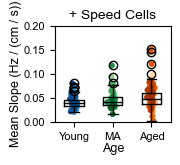

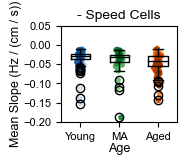

In [59]:
''' Plot Reviewer Figure 6I '''

#set up handles
from itertools import repeat
handles = []
mper = [mper5[y_ind], mper5[ma_ind], mper5[age_ind]]

for i in range(len(mper)):    
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        if c[0] == col_animal[1][0][9][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.extend(repeat(l,7))
               
#Plot Reviewer Figure 6I (left)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sslope = [sslope95[y_sind95], sslope95[ma_sind95], sslope95[age_sind95]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sslope, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sslope)):
    y = sslope[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session95[i], edgecolors = col_session95[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Slope (Hz / (cm / s))', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,0.2])
ax.set_yticks([0,0.05,0.1,0.15,0.2])
plt.savefig(save_folder + 'ReviewerFigure6Ileft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure6Ileft.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Reviewer Figure 6I (right)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sslope = [sslope5[y_sind5], sslope5[ma_sind5], sslope5[age_sind5]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sslope, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sslope)):
    y = sslope[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session5[i], edgecolors = col_session5[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('- Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Slope (Hz / (cm / s))', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([-0.2,0.05])
ax.set_yticks([-0.2,-0.15,-0.1,-0.05,0, 0.05])
plt.savefig(save_folder + 'ReviewerFigure6Iright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure6Iright.svg', dpi=400, bbox_inches='tight')
plt.show()

In [60]:
''' Statistics for Reviewer Figure 6I (left) '''
print('\nn young, MA, sessions with + speed cells:')
print(len(y_sind95),len(ma_sind95), len(age_sind95))

print('\nspeedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM')
print(str(np.round(np.mean(sslope95[y_sind95]), 4)) + ' ± ' + str(np.round(stats.sem(sslope95[y_sind95]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope95[ma_sind95]), 4)) + ' ± ' + str(np.round(stats.sem(sslope95[ma_sind95]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope95[age_sind95]), 4)) + ' ± ' + str(np.round(stats.sem(sslope95[age_sind95]), 4)))

stat, p_diff = stats.kruskal(sslope95[y_sind95],sslope95[ma_sind95],sslope95[age_sind95])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

#get what you need for multiple comparisons
import statsmodels.api as sm
import scikit_posthocs as ph

#make into dataframe
seshmice = []
seshcount = []
seshage = []
for m, session in zip(mice, sessions):
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind95,ma_sind95,age_sind95))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Slopepos = list(sslope95[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Slopepos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','slopepos'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'slopepos', group_col = 'AgeGroup', p_adjust = 'holm')


n young, MA, sessions with + speed cells:
97 58 96

speedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM
0.0404 ± 0.0012 ; 0.0463 ± 0.0023 ; 0.0513 ± 0.0024
stat = 16.312979173791746
p_session = 0.00028686765329807314


,1.0,2.0,3.0
1.0,1.000000,0.089730,0.000135
2.0,0.089730,1.000000,0.114657
3.0,0.000135,0.114657,1.000000


In [61]:
''' Statistics for Figure 6I (right) '''
print('\nn young, MA, sessions with - speed cells:')
print(len(y_sind5),len(ma_sind5), len(age_sind5))

print('speedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM')
print(str(np.round(np.mean(sslope5[y_sind5]), 4)) + ' ± ' + str(np.round(stats.sem(sslope5[y_sind5]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope5[ma_sind5]), 4)) + ' ± ' + str(np.round(stats.sem(sslope5[ma_sind5]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope5[age_sind5]), 4)) + ' ± ' + str(np.round(stats.sem(sslope5[age_sind5]), 4)))

stat, p_diff = stats.kruskal(sslope5[y_sind5],sslope5[ma_sind5],sslope5[age_sind5])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

#NEGATIVE
# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind5,ma_sind5,age_sind5))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Slopeneg = list(sslope5[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Slopeneg))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','slopeneg',])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'slopeneg', group_col = 'AgeGroup', p_adjust = 'holm')


n young, MA, sessions with - speed cells:
96 58 96
speedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM
-0.0338 ± 0.0023 ; -0.04 ± 0.0038 ; -0.0461 ± 0.0025
stat = 22.712326555845607
p_session = 1.1697174068713999e-05


,1.0,2.0,3.0
1.0,1.000000,0.052590,0.000004
2.0,0.052590,1.000000,0.037221
3.0,0.000004,0.037221,1.000000


In [62]:
''' Collect Speed Cell Trial Stability Score 

Run time: 10-15 seconds / session x 250 sessions with either type of speed cell (~ 1 hr).

'''
# set up arrays for plotting by session 
strialstabscore5 = []
strialstabscore95 = []

dt = 0.02

for m, session in zip(mice,sessions):
    
    for s in tdqm(session):
        d = data[m][s]
    
        #get file names & load data necessary
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        A = d['A']
        speed = behaviorfil[:,1]
        trial = behaviorfil[:,2]
       
        #get dict-stored data
        cell_IDs = raw.item().get('cellsfil')
        intn = d['intn'].astype(bool)
        speedcell95 = d['speedcell95']
        speedcell5 = d['speedcell5']
        speedcells95 = cell_IDs[(speedcell95 == 1) & (intn == 0)]
        speedcells5 = cell_IDs[(speedcell5 == 1) & (intn == 0)]
        
        #get spike-weighted average of speed score by trial for each speed cell population
        bytrialspeedstabilityscores95 = []          
        for i, c in enumerate(speedcells95):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            weightscore = []
            for j, t in enumerate(np.unique(trial)):
                trialidx = np.where(trial == t)[0].astype(int)
                
                trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))   
            bytrialspeedstabilityscores95 = np.append(bytrialspeedstabilityscores95, np.nansum(weightscore) / np.sum(A[:,sdx]))
            
        bytrialspeedstabilityscores5 = []
        for i, c in enumerate(speedcells5):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            weightscore = []
            for j, t in enumerate(np.unique(trial)):
                trialidx = np.where(trial == t)[0].astype(int)
                trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))
        
            bytrialspeedstabilityscores5 = np.append(bytrialspeedstabilityscores5, np.nansum(weightscore) / np.sum(A[:,sdx]))

        strialstabscore95 = np.append(strialstabscore95, np.mean(bytrialspeedstabilityscores95))
        strialstabscore5 = np.append(strialstabscore5, np.mean(bytrialspeedstabilityscores5))

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

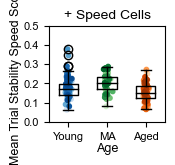

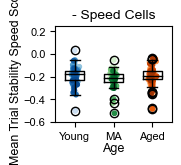

In [63]:
''' Plot Reviewer Figure 6J '''

#Reviewer Figure 6J (left)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sttscore = [strialstabscore95[y_sind95], strialstabscore95[ma_sind95], strialstabscore95[age_sind95]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sttscore, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sttscore)):
    y = sttscore[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session95[i], edgecolors = col_session95[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Trial Stability Speed Score', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,0.5])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
plt.savefig(save_folder + 'ReviewerFigure6Jleft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure6Jleft.svg', dpi=400, bbox_inches='tight')
plt.show()

#Reviewer Figure 6J (right)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sttscore = [strialstabscore5[y_sind5], strialstabscore5[ma_sind5], strialstabscore5[age_sind5]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sttscore, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sttscore)):
    y = sttscore[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session5[i], edgecolors = col_session5[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('- Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Trial Stability Speed Score', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([-0.6,0.25])
ax.set_yticks([-0.6, -0.4, -0.2, 0, 0.2])
plt.savefig(save_folder + 'ReviewerFigure6Jright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure6Jright.svg', dpi=400, bbox_inches='tight')
plt.show()

In [64]:
''' Stats for Reviewer Figure 6J (left)'''

print('\nPOS SPEED CELL RESULTS:')
print('meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM')
print(str(np.round(np.mean(strialstabscore95[y_sind95]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore95[y_sind95]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore95[ma_sind95]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore95[ma_sind95]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore95[age_sind95]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore95[age_sind95]), 4)))

stat, p_diff = stats.kruskal(strialstabscore95[y_sind95],strialstabscore95[ma_sind95],strialstabscore95[age_sind95])
print('stat = ' + str(stat))
print('p_trialstabscore = ' + str(p_diff))

#POSTIVE
# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind95,ma_sind95,age_sind95))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Scorepos = list(strialstabscore95[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Scorepos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','scorepos'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'scorepos', group_col = 'AgeGroup', p_adjust = 'holm')



POS SPEED CELL RESULTS:
meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM
0.1731 ± 0.0056 ; 0.1999 ± 0.006 ; 0.156 ± 0.0045
stat = 28.96607462804195
p_trialstabscore = 5.129757242625391e-07


,1.0,2.0,3.0
1.0,1.000000,3.011426e-04,3.394865e-02
2.0,0.000301,1.000000e+00,1.081300e-07
3.0,0.033949,1.081300e-07,1.000000e+00


In [65]:
''' Stats for Reviewer Figure 6J (right)'''

print('\nNEG SPEED CELL RESULTS:')
print('meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM')
print(str(np.round(np.mean(strialstabscore5[y_sind5]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore5[y_sind5]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore5[ma_sind5]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore5[ma_sind5]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore5[age_sind5]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore5[age_sind5]), 4)))

stat, p_diff = stats.kruskal(strialstabscore5[y_sind5],strialstabscore5[ma_sind5],strialstabscore5[age_sind5])
print('stat = ' + str(stat))
print('p_trialstabscore = ' + str(p_diff))

#NEGATIVE
# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind5,ma_sind5,age_sind5))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Scoreneg = list(strialstabscore5[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Scoreneg))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','scoreneg'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'scoreneg', group_col = 'AgeGroup', p_adjust = 'holm')


NEG SPEED CELL RESULTS:
meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM
-0.1893 ± 0.0076 ; -0.2183 ± 0.0098 ; -0.1923 ± 0.0079
stat = 7.97039442231096
p_trialstabscore = 0.018588778046836854


,1.0,2.0,3.0
1.0,1.000000,0.017911,0.561146
2.0,0.017911,1.000000,0.048342
3.0,0.561146,0.048342,1.000000
